In [56]:
import pythetatools.toyxp as toyxp
import pythetatools.likelihood as likelihood
from pythetatools.config import *
from pythetatools.config_visualisation import *
from pythetatools.config_fc import param_values_FC
import pythetatools.pvalues as pvalues

from pythetatools.base_analysis import get_double_sided_gaussian_zscore, sigma_to_CL
from pythetatools.base_visualisation import show_minor_ticks
from pythetatools.file_manager import read_cont
from pythetatools.feldman_cousins import get_critical_values
from collections import defaultdict
import pythetatools.feldman_cousins as feldman_cousins

import numpy as np
from pathlib import Path
from scipy.integrate import simps
from matplotlib import pyplot as plt
import seaborn as sns
import uproot
import matplotlib.colors as colors
from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use(t2k_style)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dir_ver = 'OA2023'
octant_to_title = {0:'Lower Octant', 1:'Upper Octant'}
suffix = {'delta':'', 'sin223':'sin223'}

outdir_path = f'{outputs_dir}/plots/{dir_ver}/pvalues/'
os.makedirs(outdir_path, exist_ok=True)


# Mass ordering tests

In [3]:

def Plot_MO_dchi2(ax, base_dir_toys_true_no, base_dir_toys_true_io, base_dir_data, true_dcp_str, save=True):
    avnllh = [None]*2
    base_dirs = [base_dir_true_no, base_dir_true_io]

    #Read data-fit
    file_pattern = f"{base_dir_data}/marg*.root"
    grid_x, avnllh_df, param_name_x = likelihood.load_1D_array(file_pattern)
    avnllh_df = avnllh_df.reshape(avnllh_df.size//2, 2) #remove additional dimension remained for cont.osc.param with 1 point grid
    
    for true_mh in range(2):
        file_pattern = f"{base_dirs[true_mh]}/marg*.root"
        grid_x, AvNLL_pergrid_pertoy, param_name_x  = likelihood.load_1D_array(file_pattern)
        if true_dcp_str == 'HC':
            avnllh[true_mh] = AvNLL_pergrid_pertoy.reshape(AvNLL_pergrid_pertoy.size//2, 2)
        else:
            llhood = np.exp(-AvNLL_pergrid_pertoy)
            llhood_marginal = simps(llhood, grid_x, axis=2) #Marginalize over delta cp
            avnllh[true_mh] = -np.log(llhood_marginal)

    dchi2_no = 2*(avnllh[0][:, 0] - avnllh[0][:, 1])
    dchi2_io = 2*(avnllh[1][:, 0] - avnllh[1][:, 1])
    dchi2_df = 2*(avnllh_df[:, 0] - avnllh_df[:, 1])[0]

    pvalues.plot_dchi2_distr(ax, dchi2_no, dchi2_df, 0, label=f'True {mo_to_title[0]}', left=False, hypothesis='MO')
    pvalues.plot_dchi2_distr(ax, dchi2_io, dchi2_df, 1, label=f'True {mo_to_title[1]}', left=True, hypothesis='MO')

    p_io = pvalues.get_pvalue(dchi2_io, dchi2_df, 'left')
    p_no = pvalues.get_pvalue(dchi2_no, dchi2_df, 'right')
    
    percentiles_no = pvalues.get_percentiles(dchi2_no)
    percentiles_io = pvalues.get_percentiles(dchi2_io)

    if true_dcp_str=='HC':
        np.save(f"{outputs_dir}/files/{dir_ver}/pvalues/MO_percentiles_truemh0_HC.npy", percentiles_no)
        np.save(f"{outputs_dir}/files/{dir_ver}/pvalues/MO_percentiles_truemh1_HC.npy", percentiles_io)
    else:
        np.save(f"{outputs_dir}/files/{dir_ver}/pvalues/MO_percentiles_truemh0_truedelta{true_dcp_str}.npy", percentiles_no)
        np.save(f"{outputs_dir}/files/{dir_ver}/pvalues/MO_percentiles_truemh1_truedelta{true_dcp_str}.npy", percentiles_io)
        
    ax.set_yscale('log')
    
    ymin, ymax = ax.get_ylim()
    
    #ax.set_ylim(0, ymax * 10)
    ax.set_xlabel("$\chi^2_{NO} - \chi^2_{IO} $")
    ax.set_xlim(-15, 15)

    ax.text(0.05, 0.9, f'$p_{{0}}(IO)$={pvalues.round_to_3(p_io)}', transform=ax.transAxes, fontsize=18 )
    ax.text(0.05, 0.8, f'$p_{{0}}(NO)$={pvalues.round_to_3(p_no)}', transform=ax.transAxes, fontsize=18 )

    if true_dcp_str == 'HC':
        ax.set_title("Posterior $\delta_{CP}$", loc='right')
    else:
        ax.set_title(f"$\delta_{{CP}}^{{True}}={round(float(true_dcp_str), 2)}$", loc='right')

    ax.axvline(dchi2_df, color='black', label=f'Data-fit \n ($\Delta\chi^2 = {np.round(dchi2_df, 2)}$)', ls='--', linewidth=2)
    ax.legend(framealpha=1, loc='upper right', bbox_to_anchor = (0.99, 1), fontsize=18)

    if save:
        fig.savefig(f'{outdir_path}/Fixed_delta_{true_dcp_str}_dchi2_distr_mo_pvalues.pdf', bbox_inches='tight')


## Posterior $\delta_{CP}$

Number of entries in 'MargTemplate': 40.
No continous parameters are found. Hopefully you do p-values studies
Grid sizes: [1] for parameters ['none']
Number of entries in 'MargTemplate': 10000000.
No continous parameters are found. Hopefully you do p-values studies
Grid sizes: [1] for parameters ['none']
Number of entries in 'MargTemplate': 10000000.
No continous parameters are found. Hopefully you do p-values studies
Grid sizes: [1] for parameters ['none']


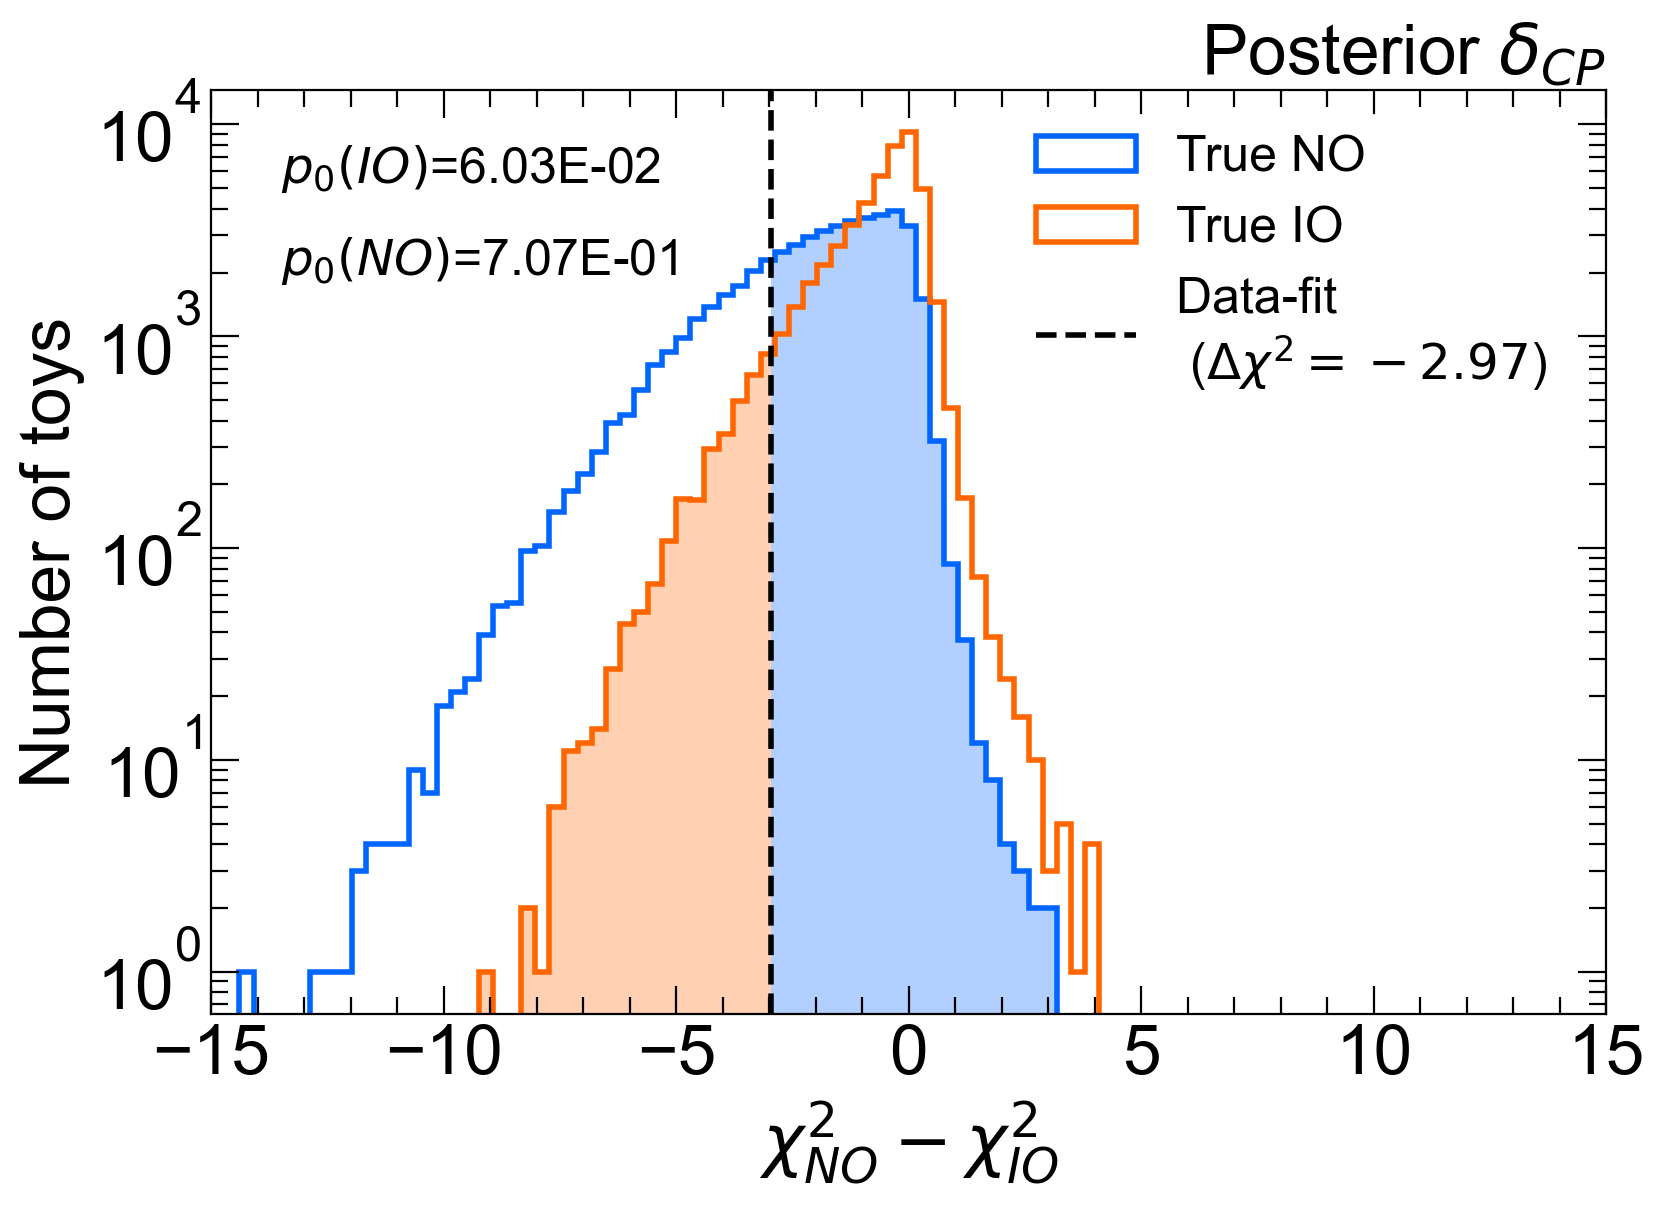

In [4]:
base_dir_data = f"{inputs_dir}/{dir_ver}/MargTemplates/MargTemplates_DataFit_OA2023_mh_400k_p-theta"
base_dir_true_no = f"{inputs_dir}/{dir_ver}/MargTemplates/MargTemplates_OA2023_HFC_50ktoys_IHmhfixed_mh_100k_p-theta_NH_mode_0"
base_dir_true_io = f"{inputs_dir}/{dir_ver}/MargTemplates/MargTemplates_OA2023_HFC_50ktoys_IHmhfixed_mh_100k_p-theta_IH_mode_0"

fig, ax = plt.subplots()
Plot_MO_dchi2(ax, base_dir_true_no, base_dir_true_io, base_dir_data, 'HC')

## Fixed $\delta_{CP}$

Number of entries in 'MargTemplate': 40.
No continous parameters are found. Hopefully you do p-values studies
Grid sizes: [1] for parameters ['none']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 40.
No continous parameters are found. Hopefully you do p-values studies
Grid sizes: [1] for parameters ['none']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 40.
No continous parameters are found. Hopefully you do p-values studies
Grid sizes: [1] for parameters ['none']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in '

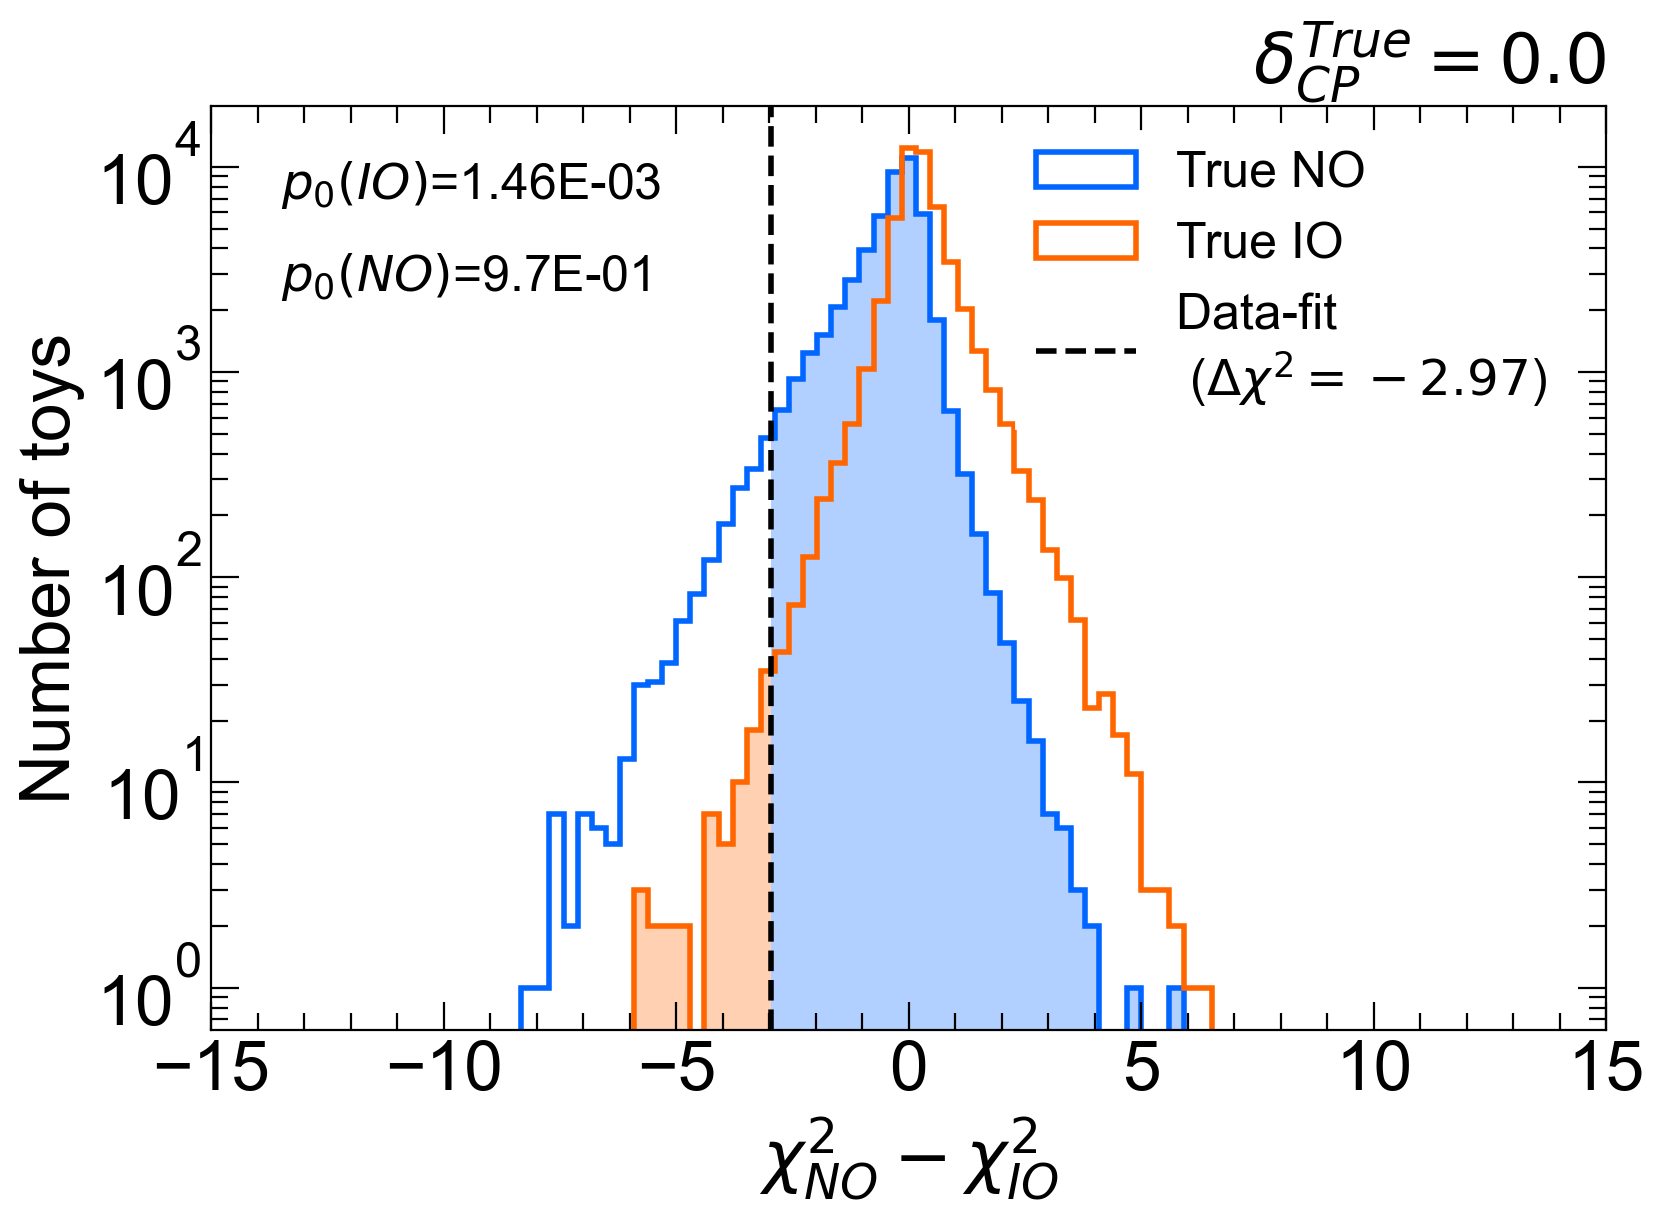

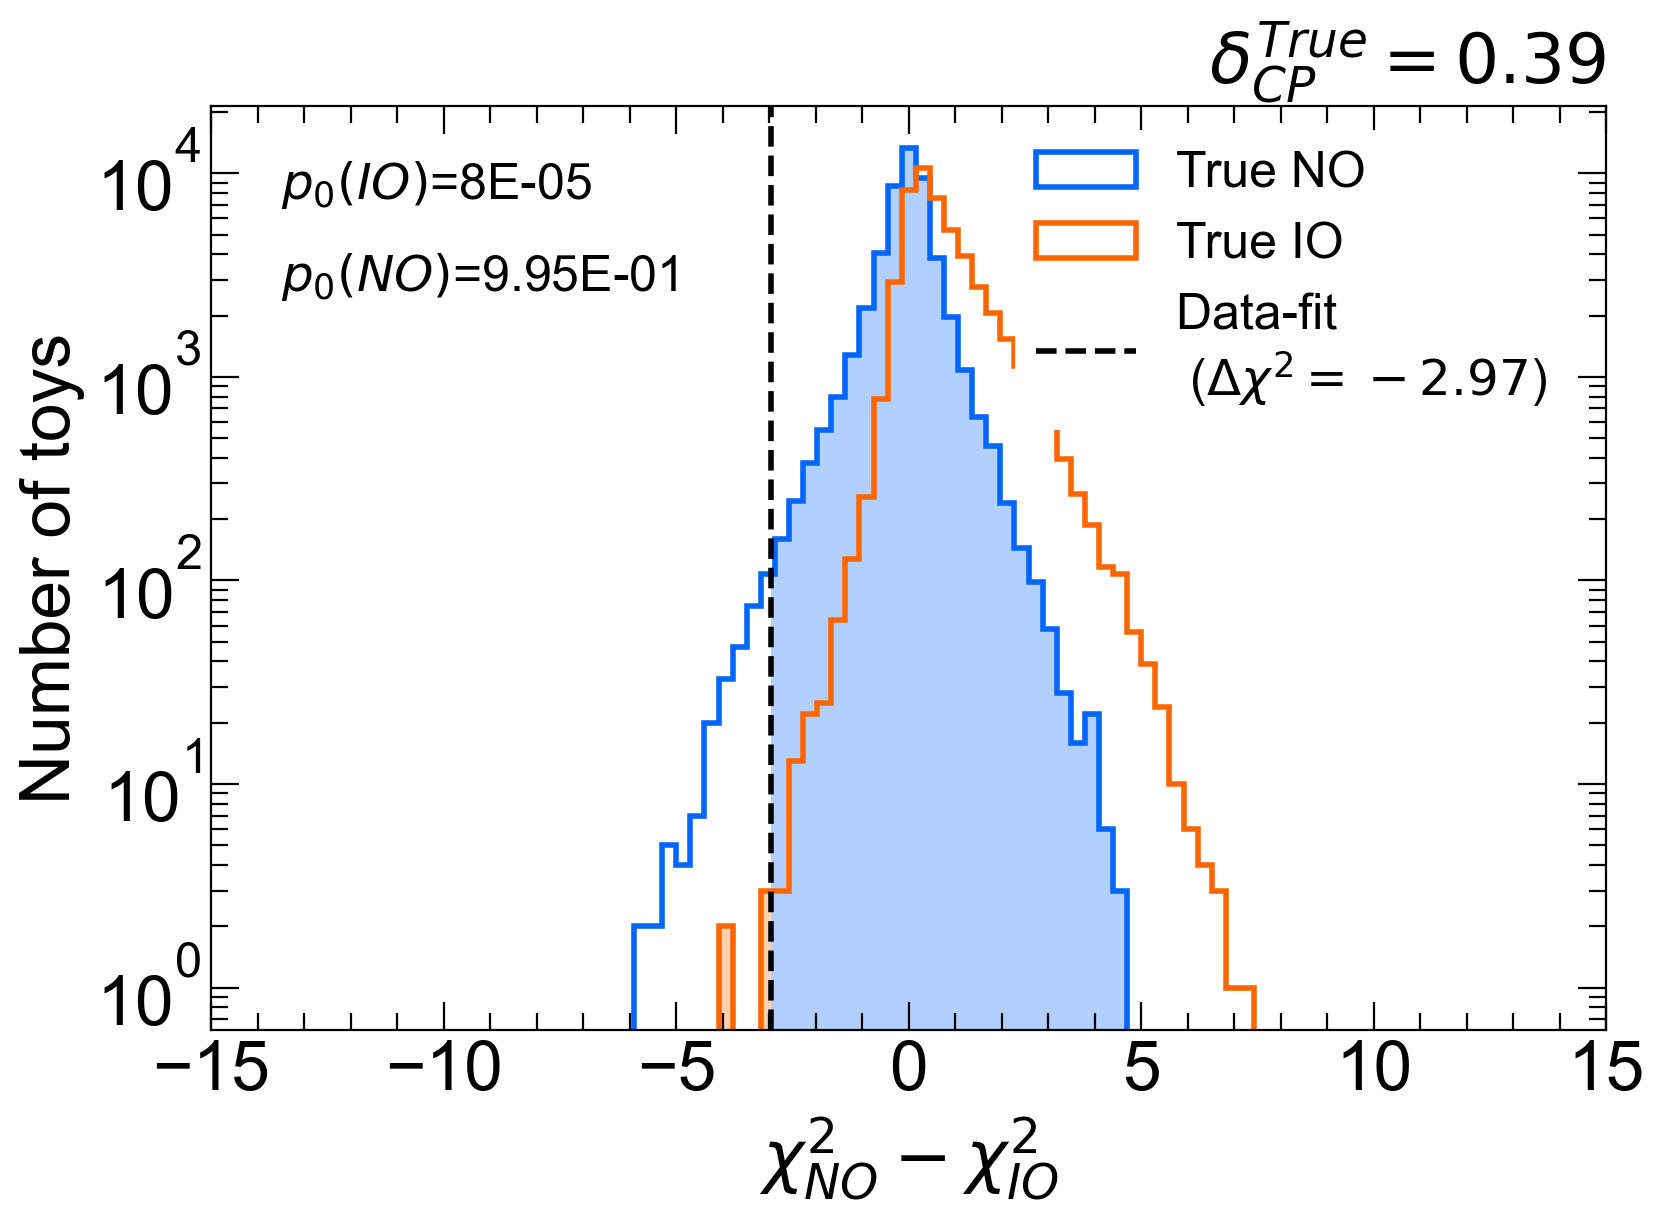

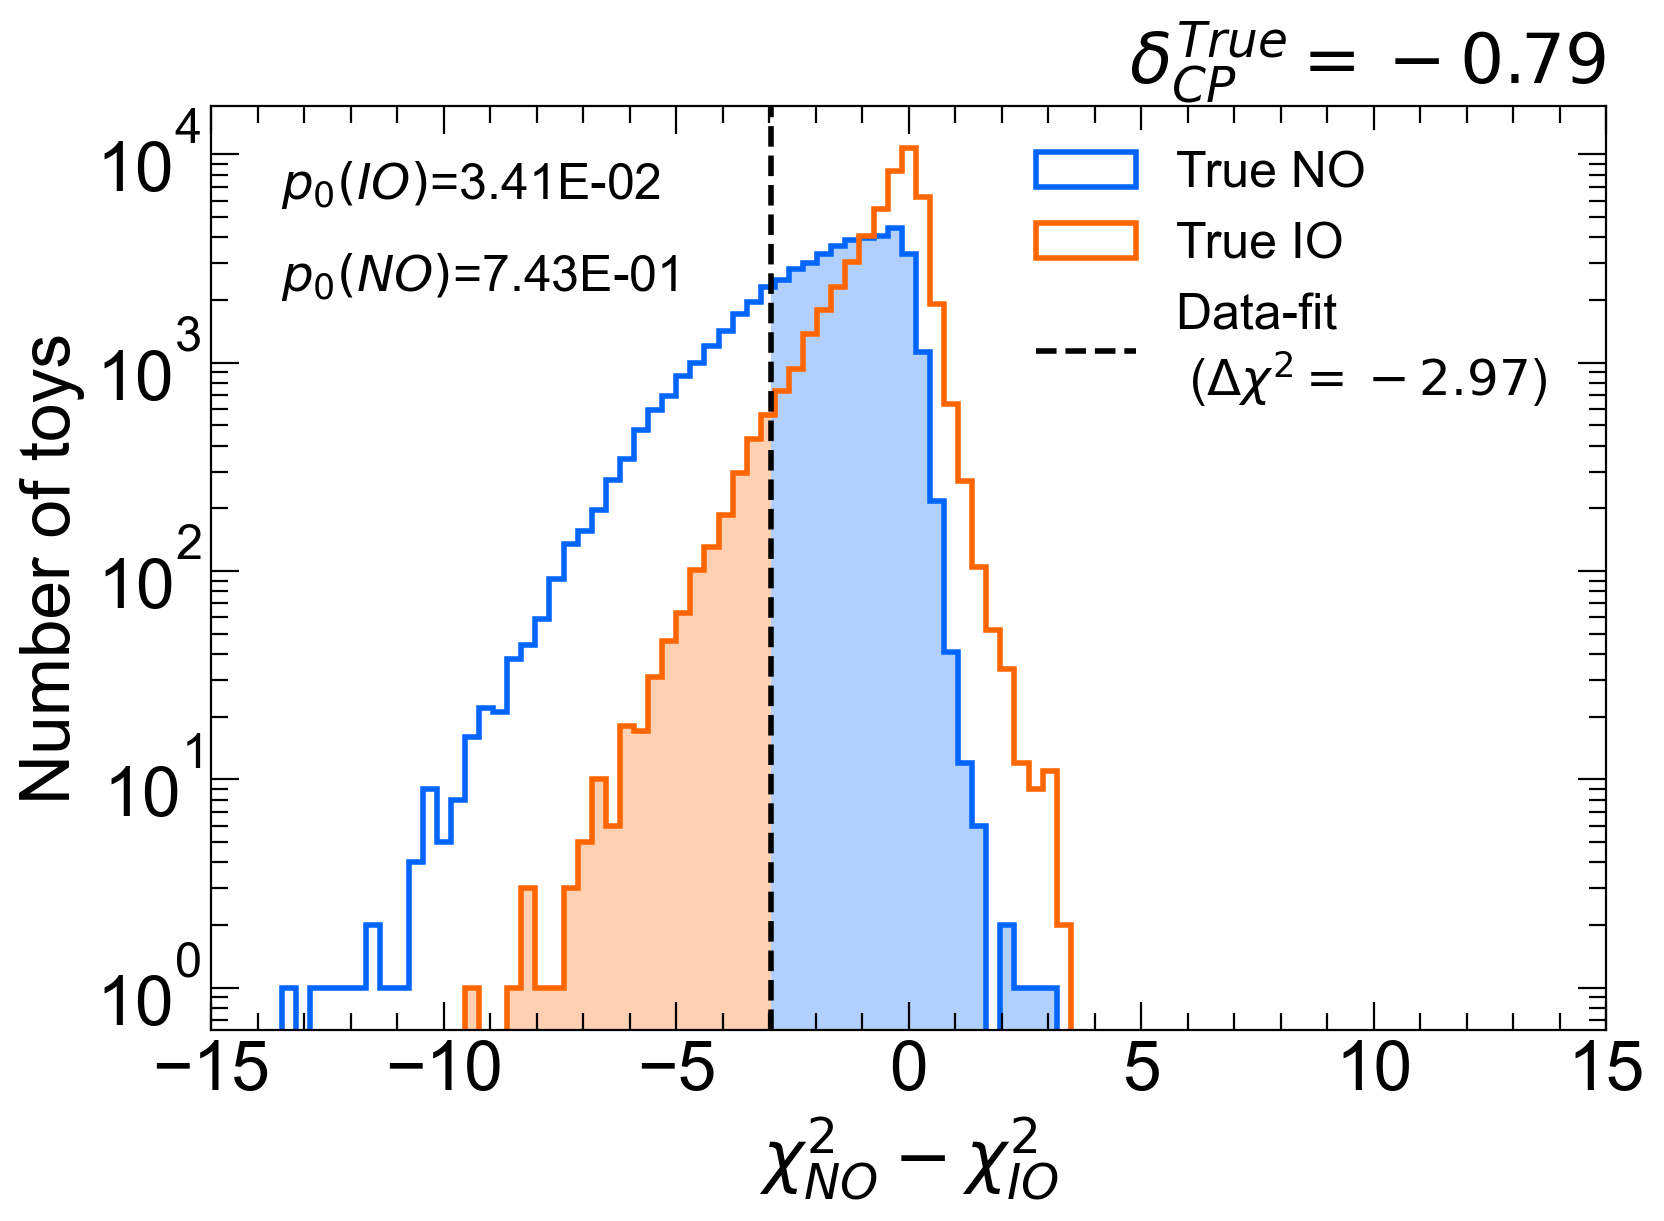

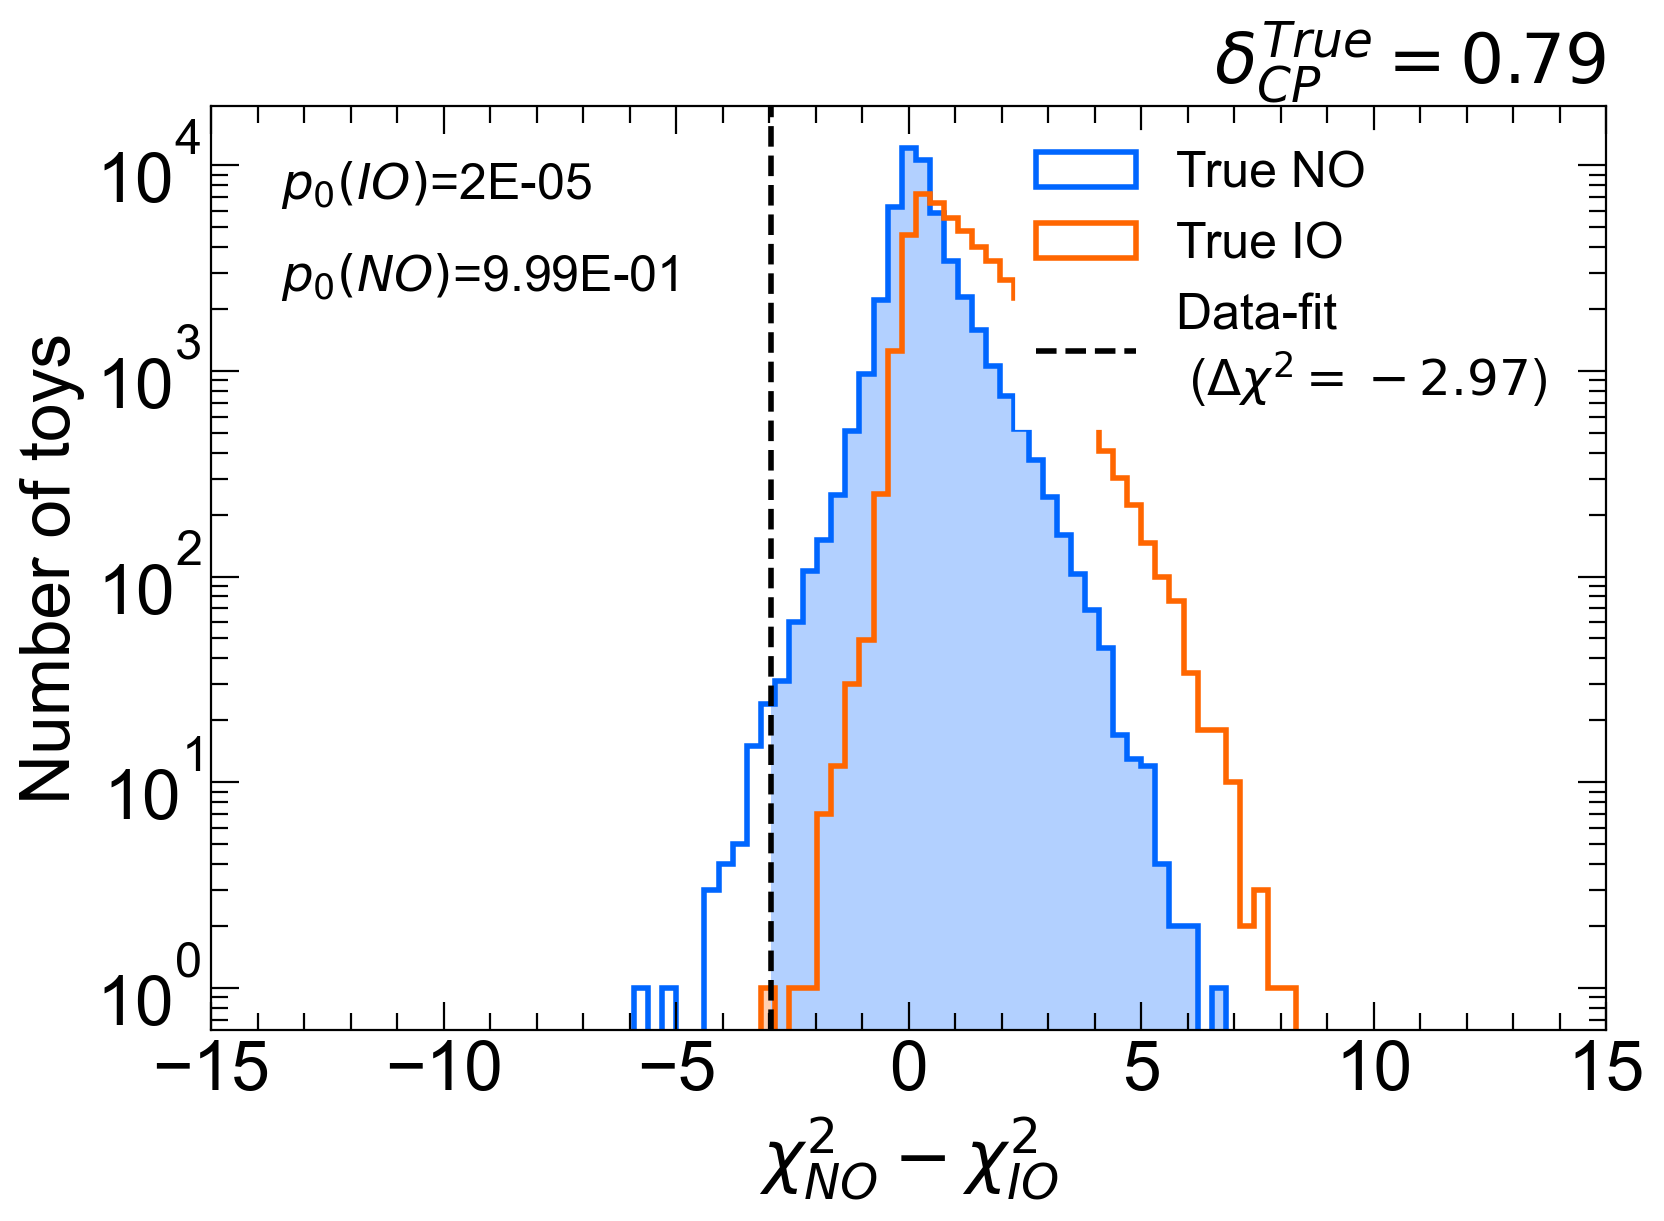

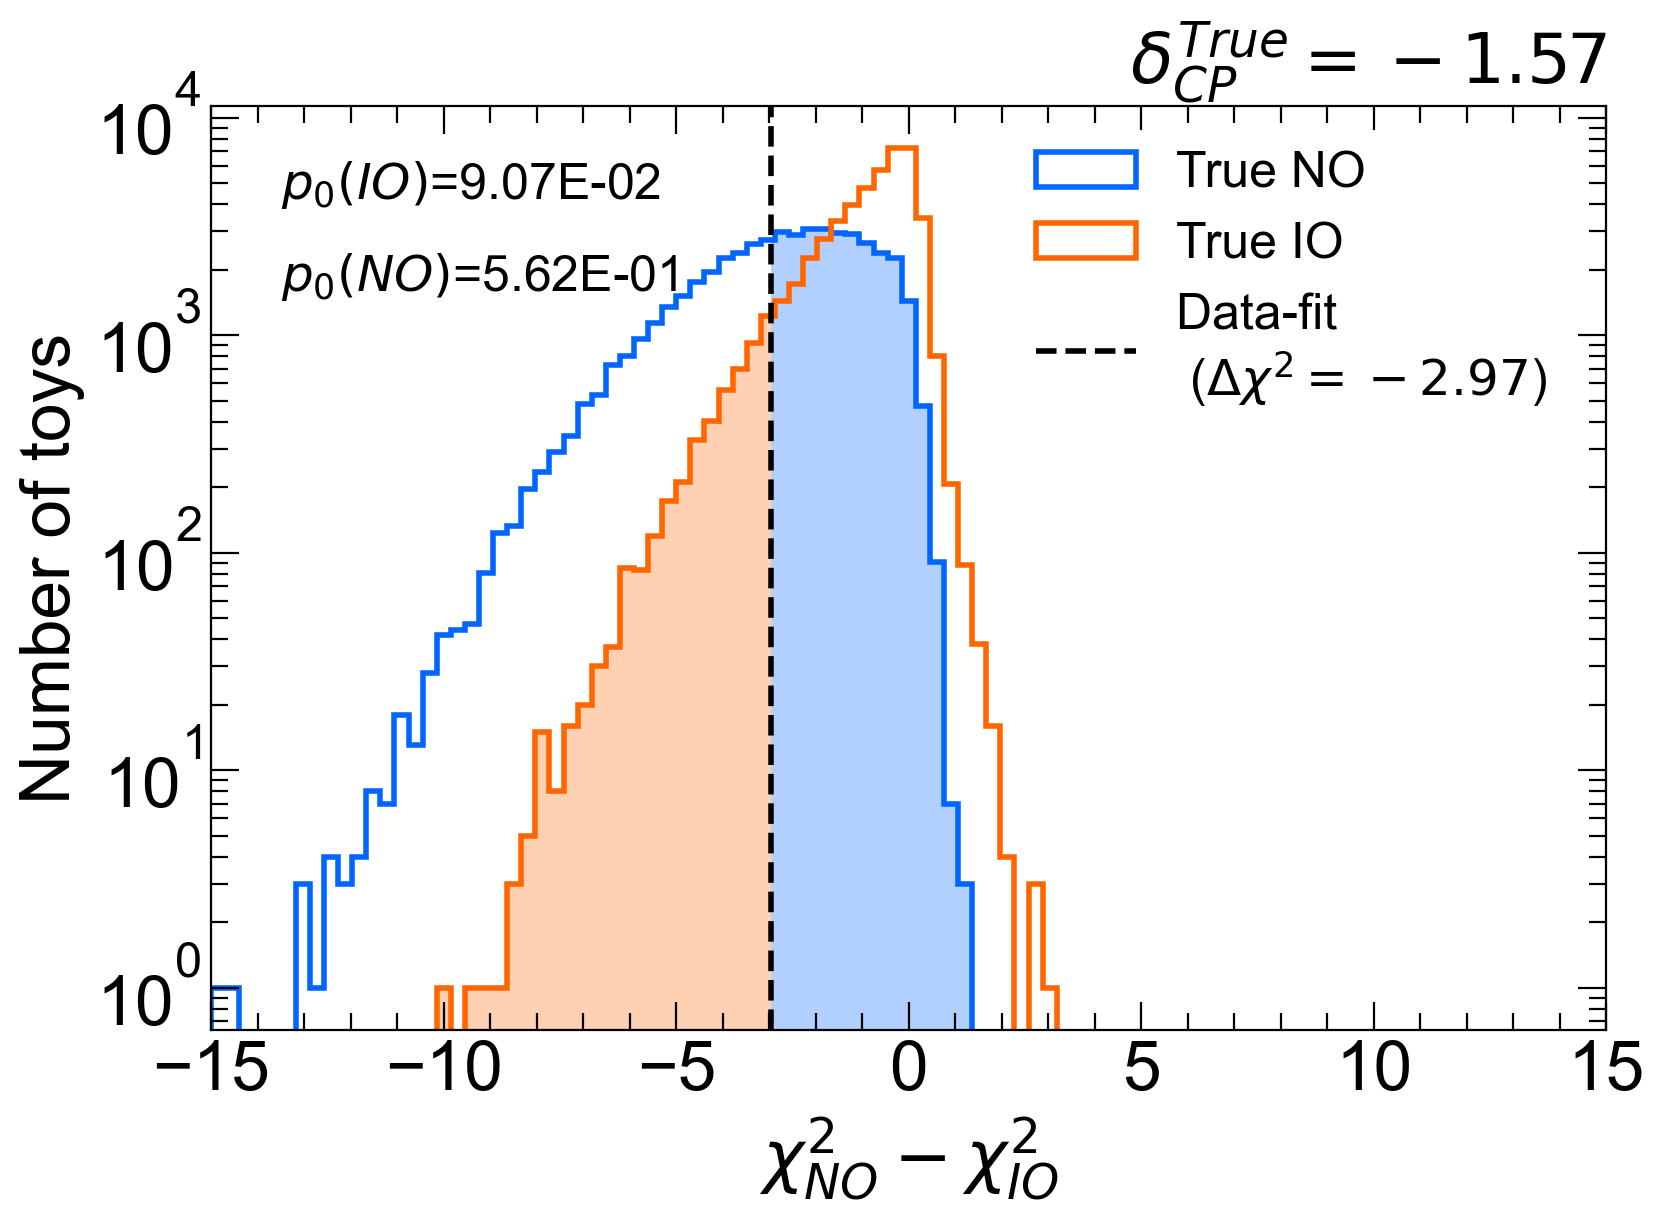

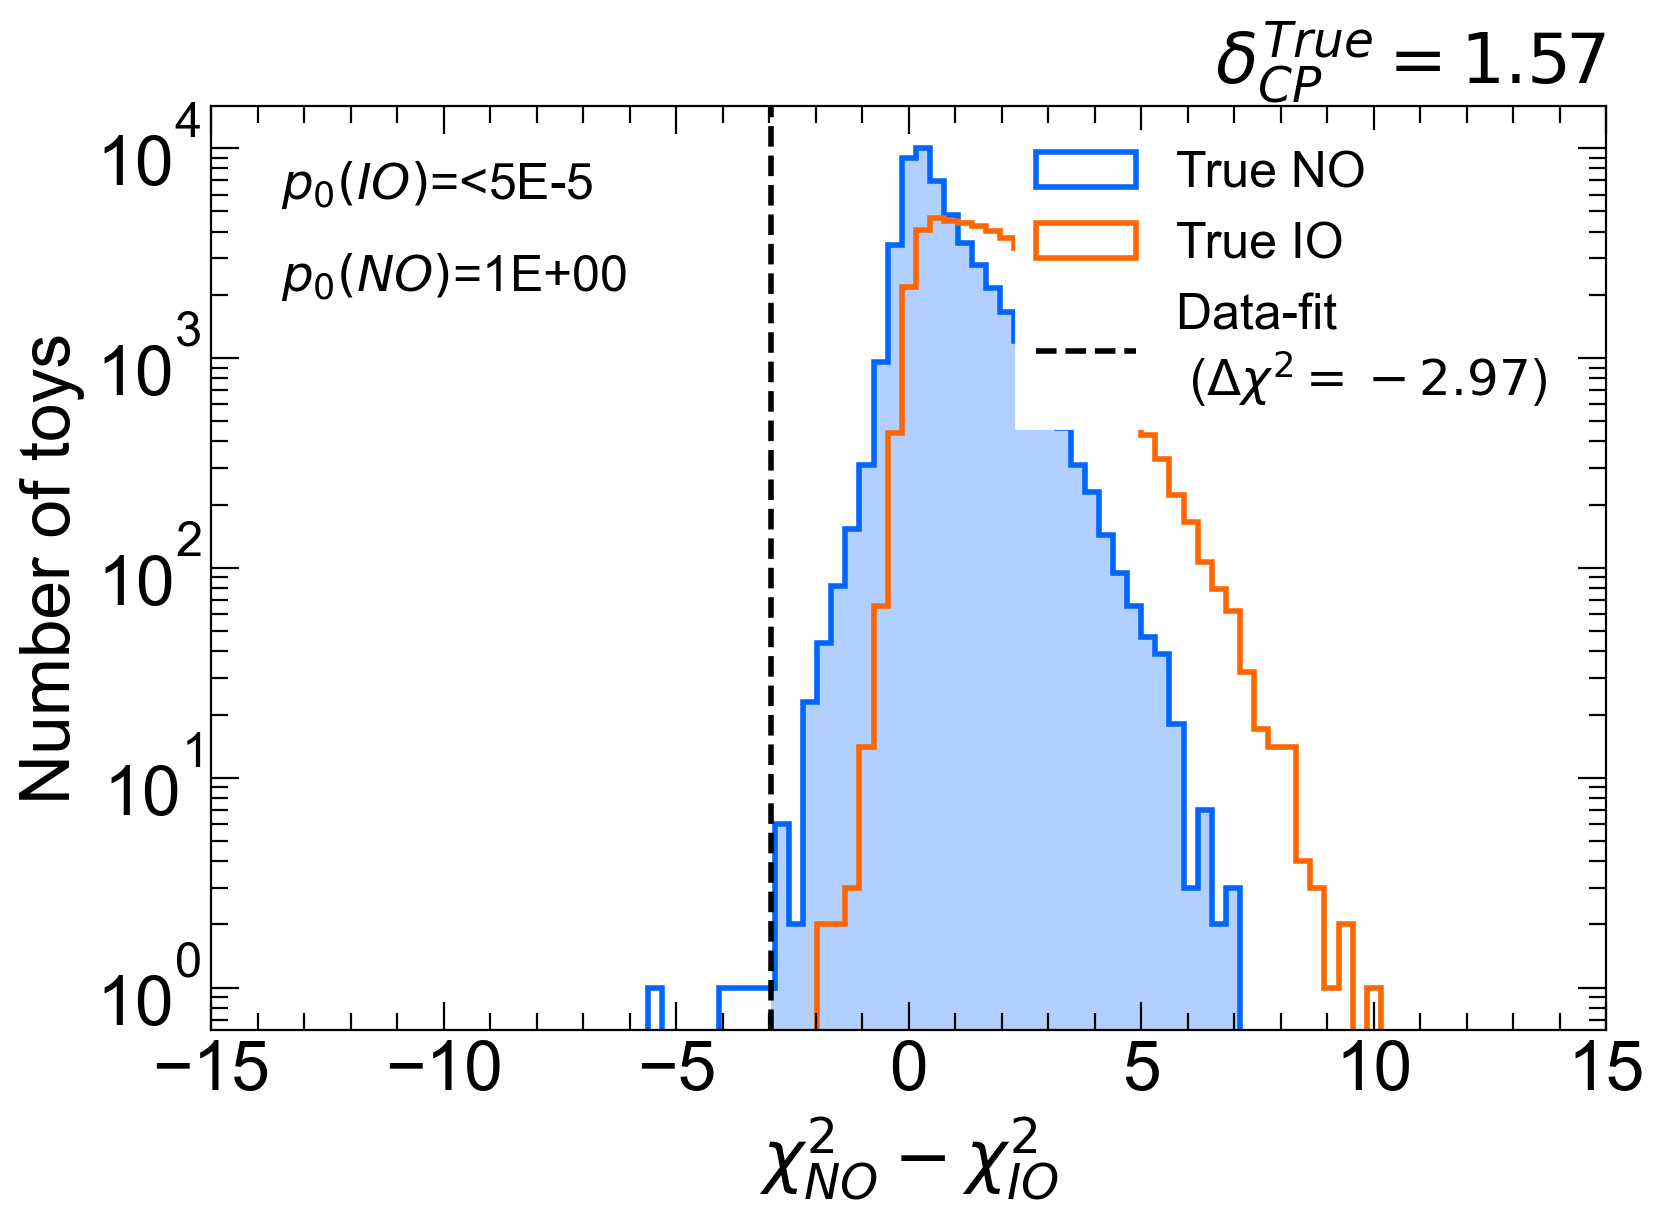

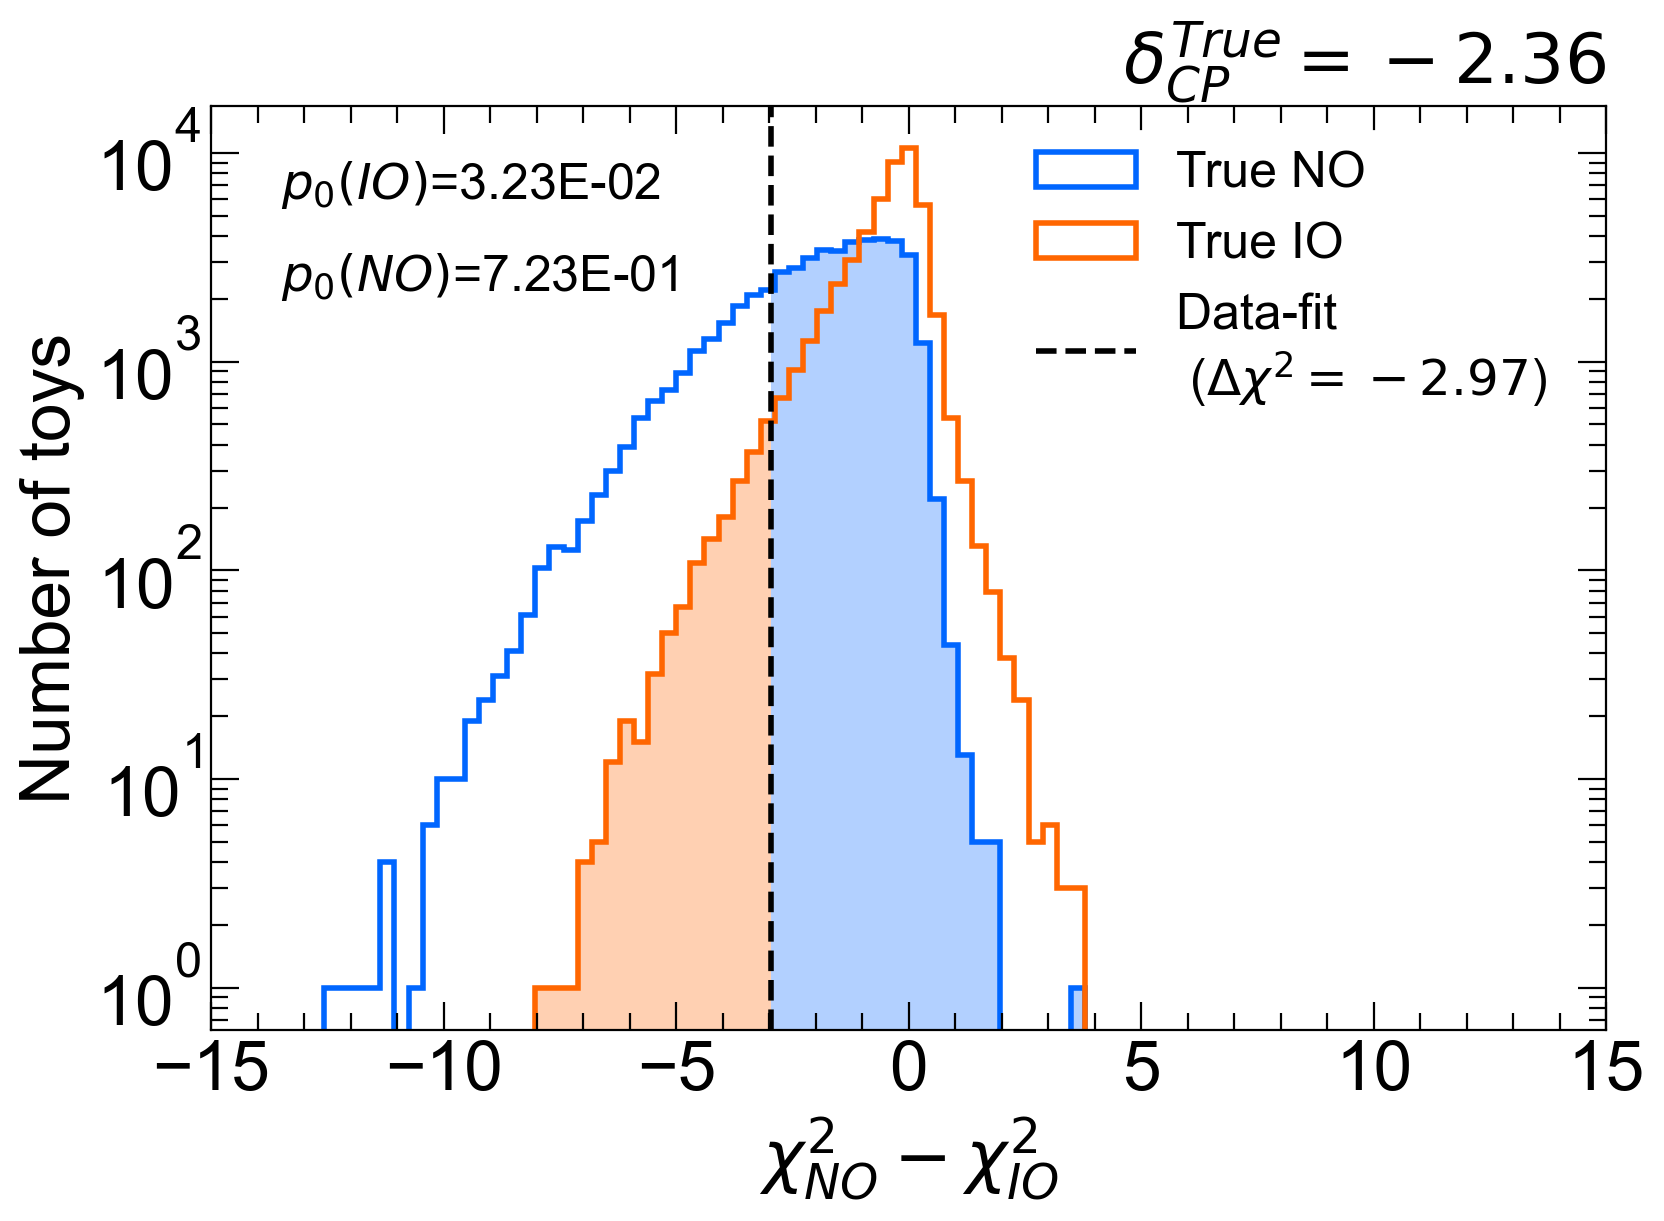

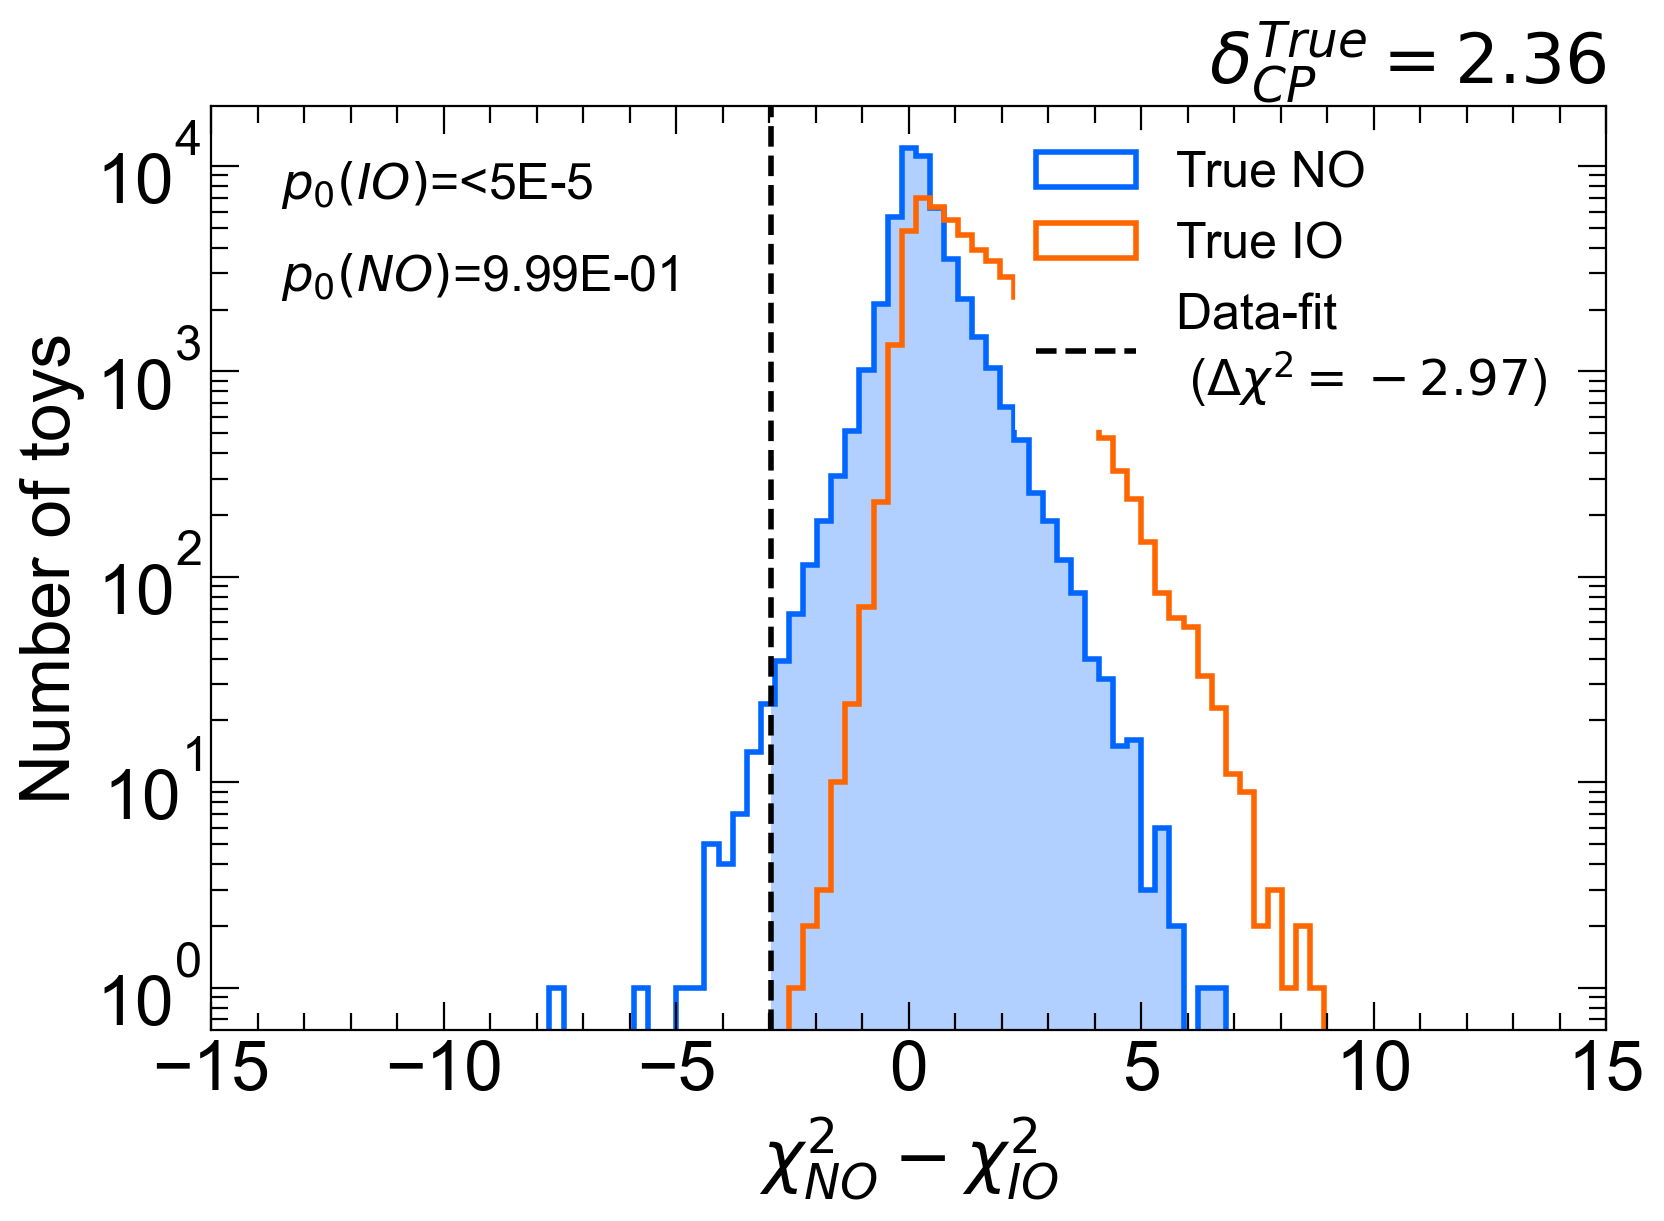

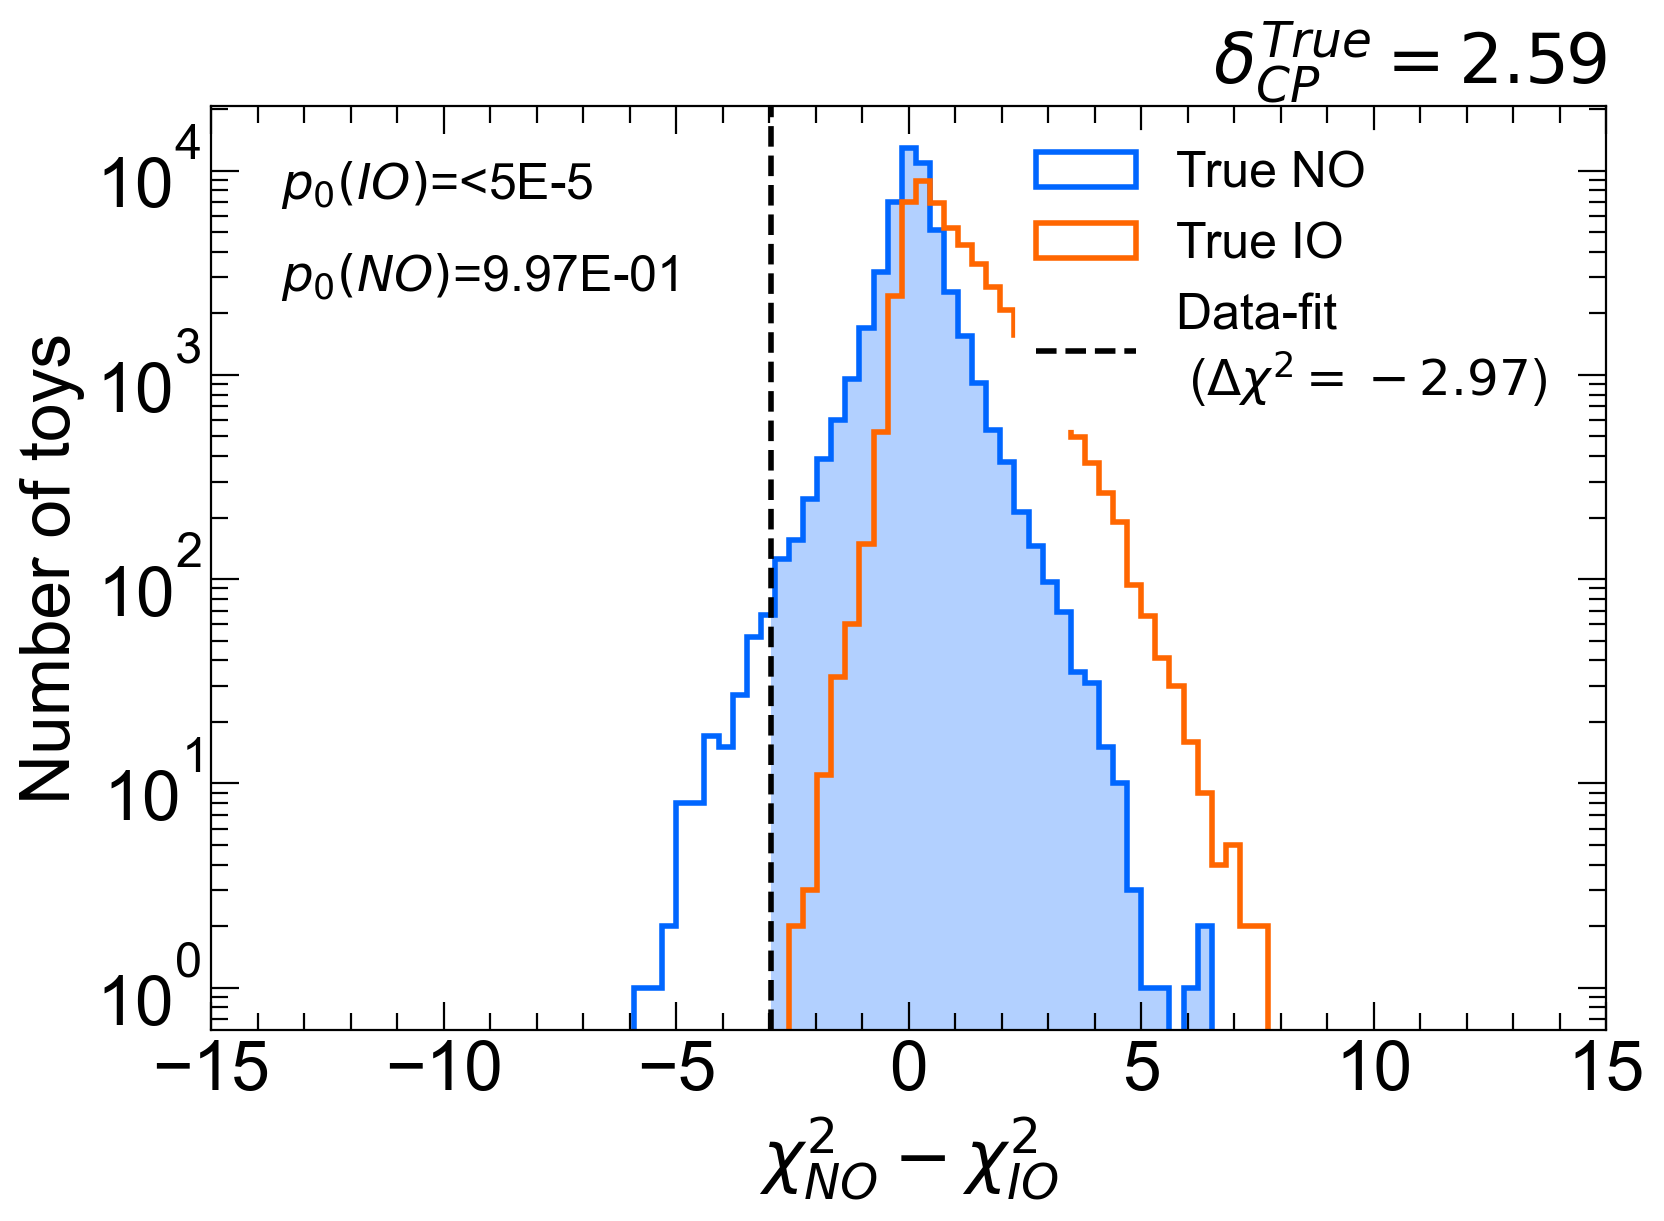

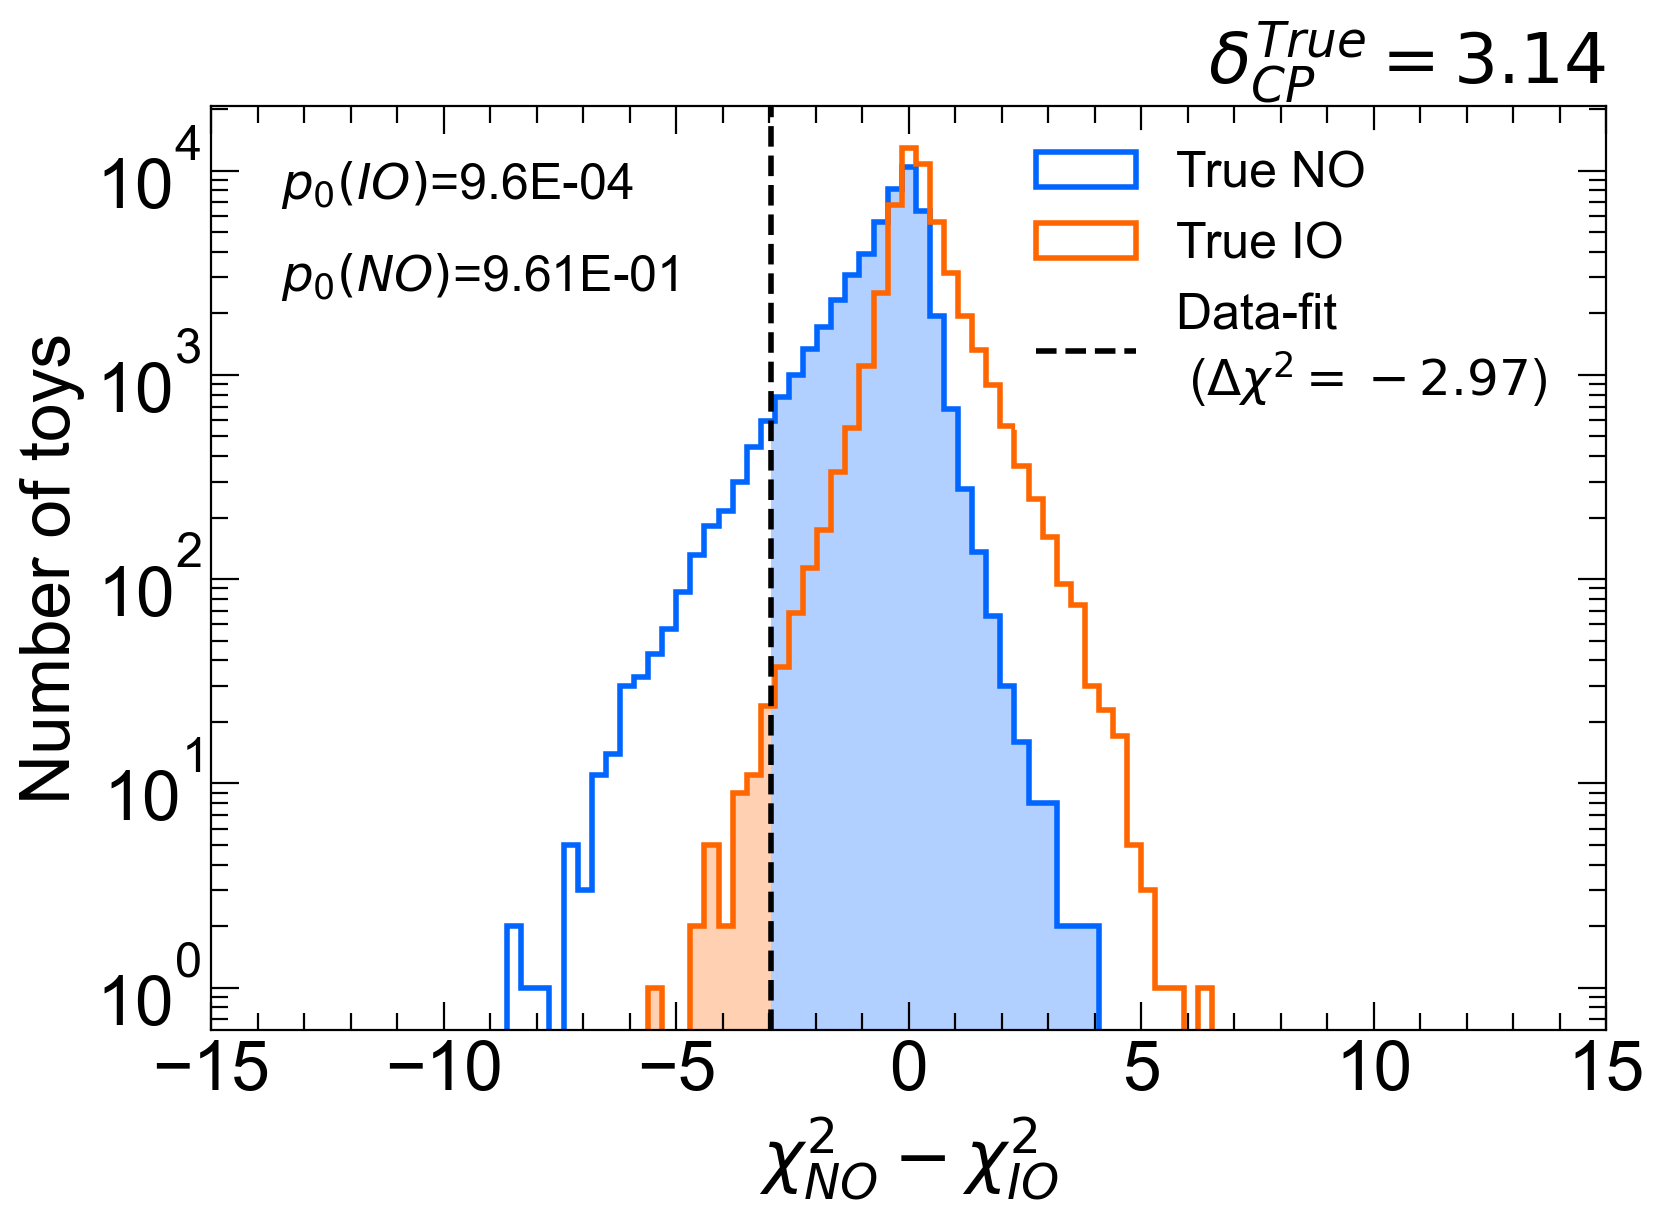

In [8]:
base_dir_data = f"{inputs_dir}/{dir_ver}/MargTemplates/MargTemplates_DataFit_OA2023_mh_400k_p-theta"

for true_dcp_str in param_values_FC['delta']:
    base_dir_true_no = f"{inputs_dir}/{dir_ver}/FC/MargTemplates_LucileThesis_fit_FC_{true_dcp_str}_0_FullSyst_wRC_etheta_ptheta_delta"
    base_dir_true_io = f"{inputs_dir}/{dir_ver}/FC/MargTemplates_LucileThesis_fit_FC_{true_dcp_str}_1_FullSyst_wRC_etheta_ptheta_delta"
    fig, ax = plt.subplots()
    Plot_MO_dchi2(ax, base_dir_true_no, base_dir_true_io, base_dir_data, true_dcp_str)

# Octant studies

## Plot $\Delta \chi^2$

Number of entries in 'MargTemplate': 3240.
Grid sizes: [81] for parameters ['sin223']
664.6842496466196 664.6842496466196


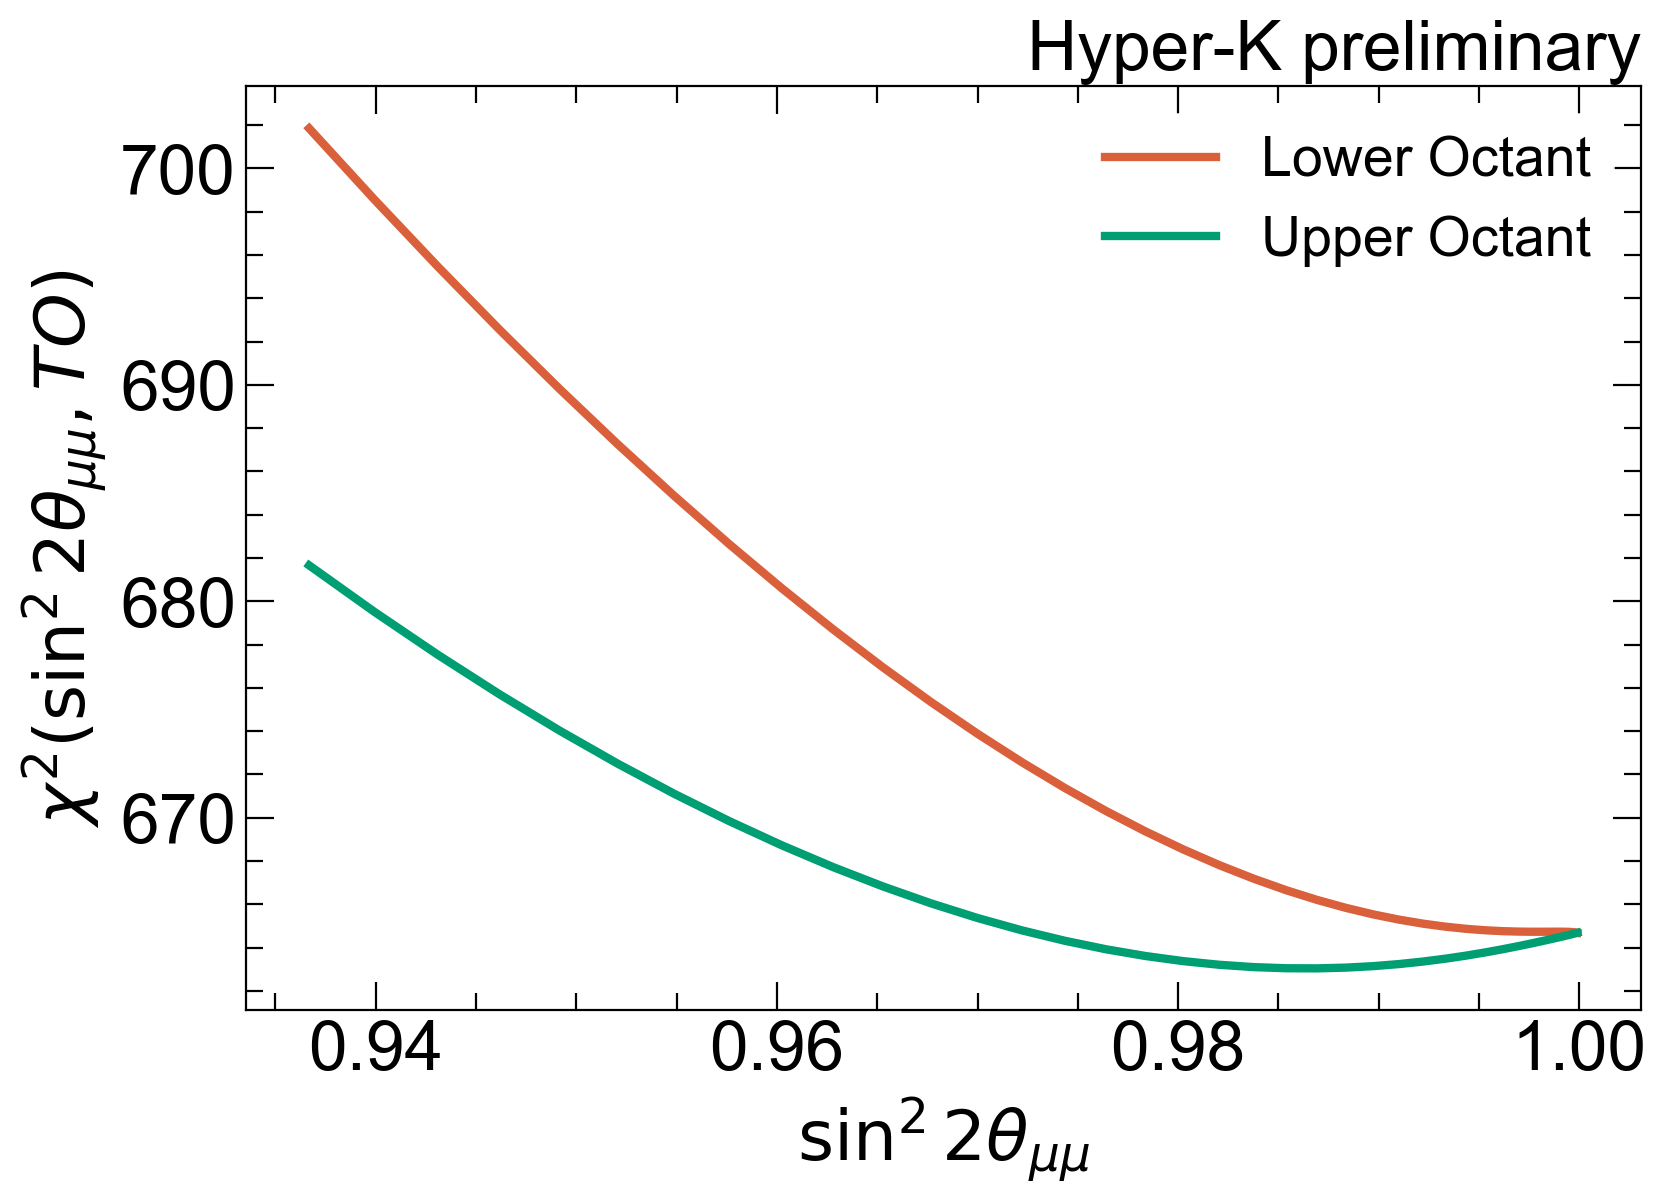

In [33]:
param = 'sin223'
prefix = 'DataFit'
mode=0
dir_ver = 'OA2023'
octant_border = 0.510

basename_directory = f"MargTemplates_{prefix}_{param}_100k_p-theta_mode_{mode}"
indir = f"{inputs_dir}/{dir_ver}/MargTemplates/{basename_directory}"
file_pattern = f"{inputs_dir}/{dir_ver}/MargTemplates/{basename_directory}/marg*.root"

grid_x, avnllh, param_name = likelihood.load_1D_array(file_pattern)
grid_sinmumu = pvalues.sinttt_to_sinmumu(grid_x)[:38] # works only if total number of grid points is 81
L = len(grid_sinmumu)

llhood = np.exp(-avnllh)
llhood_marg_mo = simps(llhood, [0, 1], axis=1)[0]
llhood_marginal_lo = simps(llhood_marg_mo[:L], grid_sinmumu, axis=0)/(np.max(grid_sinmumu) - np.min(grid_sinmumu))
llhood_marginal_uo = simps(llhood_marg_mo[2*L-2:L-2:-1], grid_sinmumu, axis=0)/(np.max(grid_sinmumu) - np.min(grid_sinmumu))

avnllh_octant_df = np.c_[-np.log(llhood_marginal_lo), -np.log(llhood_marginal_uo)]

fig, ax = plt.subplots()

ax.plot(grid_sinmumu, -2*np.log(llhood_marg_mo)[:L], color=vermilion, label='Lower Octant')
ax.plot(grid_sinmumu, -2*np.log(llhood_marg_mo)[2*L-2:L-2:-1], color=bluish_green, label='Upper Octant')

print(-2*np.log(llhood_marg_mo)[:L][-1], -2*np.log(llhood_marg_mo)[2*L-2:L-2:-1][-1])

ax.set_xlabel('$\sin^2 2\\theta_{\mu \mu}$')
ax.set_ylabel('$\chi^2 (\sin^2 2\\theta_{\mu \mu}, TO)$')
ax.set_title(tag, loc='right')
ax.legend()
show_minor_ticks(ax)

fig.savefig(f'{outputs_dir}/plots/{dir_ver}/dchi2/dchi2_datafit_sinthmumu_octant.pdf', bbox_inches='tight')


## Plot $\Delta \chi^2$ distribution

In [32]:

def Plot_octant_dchi2(ax, base_dir_toys_true_uo, base_dir_toys_true_lo, base_dir_data, octant_pair, save=True):
    base_dirs = [base_dir_toys_true_uo, base_dir_toys_true_lo]

    #Read data-fit
    file_pattern = f"{base_dir_data}/marg*.root"
    grid_x, avnllh, param_name_x = likelihood.load_1D_array(file_pattern)
    grid_sinmumu = pvalues.sinttt_to_sinmumu(grid_x)[:38] #Depends on chosen grid on sin223
    llhood = np.exp(-avnllh)
    llhood_marg_mo = simps(llhood, [0, 1], axis=1)[0]
    llhood_marginal_lo = simps(llhood_marg_mo[:38], grid_sinmumu, axis=0)/(np.max(grid_sinmumu) - np.min(grid_sinmumu)) #Depends on chosen grid on sin223
    llhood_marginal_uo = simps(llhood_marg_mo[74:36:-1], grid_sinmumu, axis=0)/(np.max(grid_sinmumu) - np.min(grid_sinmumu)) #Depends on chosen grid on sin223
    avnllh_octant_df = np.c_[-np.log(llhood_marginal_lo), -np.log(llhood_marginal_uo)]
    
    avnllh = [None]*2
    for true_to in range(2):
        file_pattern = f"{base_dirs[true_to]}/marg*.root"
        grid_x, AvNLL_pergrid_pertoy, param_name_x = likelihood.load_1D_array(file_pattern)
        grid_sinmumu = pvalues.sinttt_to_sinmumu(grid_x)[4:43] #Depends on chosen grid on sin223
        llhood = np.exp(-AvNLL_pergrid_pertoy)
        llhood_marg_mo = simps(llhood, np.array([0, 1]), axis=1) #Marginalize over mo
        llhood_marginal_lo = simps(llhood_marg_mo[:, 4:43], grid_sinmumu, axis=1) #Depends on chosen grid on sin223
        llhood_marginal_uo = simps(llhood_marg_mo[:, 81:43-2:-1], grid_sinmumu, axis=1) #Depends on chosen grid on sin223
        avnllh[true_to] = np.c_[-np.log(llhood_marginal_lo), -np.log(llhood_marginal_uo)]

    dchi2_lo = 2*(avnllh[0][:, 1] - avnllh[0][:, 0]) #Upper - Lower octant
    dchi2_uo = 2*(avnllh[1][:, 1] - avnllh[1][:, 0])
    dchi2_df = 2*(avnllh_octant_df[:, 1]-avnllh_octant_df[:, 0])[0]
    
    pvalues.plot_dchi2_distr(ax, dchi2_lo, dchi2_df, 0, f"True LO", True, 'octant')
    pvalues.plot_dchi2_distr(ax, dchi2_uo, dchi2_df, 1, f"True UO", False, 'octant')

    p_lo = pvalues.get_pvalue(dchi2_lo, dchi2_df, 'left')
    p_uo = pvalues.get_pvalue(dchi2_uo, dchi2_df, 'right')

    percentiles_uo = pvalues.get_percentiles(dchi2_uo)
    percentiles_lo = pvalues.get_percentiles(dchi2_lo)

    np.save(f"{outputs_dir}/files/{dir_ver}/pvalues/Octant_percentiles_true{param_name}{octant_pair[0]}.npy", percentiles_lo)
    np.save(f"{outputs_dir}/files/{dir_ver}/pvalues/Octant_percentiles_true{param_name}{octant_pair[1]}.npy", percentiles_uo)
    
    ymin, ymax = ax.get_ylim()

    ax.set_ylim(0, ymax * 1.5)
    ax.set_xlim(-18, 10)
    ax.set_xlabel("$\chi^2_{UO} - \chi^2_{LO} $")
    ax.set_title(f"$\sin^2 \\theta^{{True}}_{{\mu \mu}}={round(pvalues.sinttt_to_sinmumu(octant_pair[0]), 4)}$", loc='right')
    
    ax.text(0.63, 0.9, f'$p_{{0}}(LO)$={pvalues.round_to_3(p_lo)}', transform=ax.transAxes, fontsize=18 )
    ax.text(0.63, 0.8, f'$p_{{0}}(UO)$={pvalues.round_to_3(p_uo)}', transform=ax.transAxes, fontsize=18 )
    
    ax.axvline(dchi2_df, color='black', label=f'Data-fit ($\Delta\chi^2 = {np.round(dchi2_df, 2)}$)', ls='--', linewidth=2)
    ax.legend(framealpha=0, loc='upper left', bbox_to_anchor = (0.0, 1))

    fig.savefig(f'{outputs_dir}/plots/{dir_ver}/pvalues/Fixed_th23_{octant_pair[0]}_vs_{octant_pair[1]}_pvalues.pdf', bbox_inches='tight')


Number of entries in 'MargTemplate': 3240.
Grid sizes: [81] for parameters ['sin223']
Number of entries in 'MargTemplate': 3240000.
Grid sizes: [81] for parameters ['sin223']
Number of entries in 'MargTemplate': 3240000.
Grid sizes: [81] for parameters ['sin223']
[0.42, 0.6] 0.7762 0.2843
Number of entries in 'MargTemplate': 3240.
Grid sizes: [81] for parameters ['sin223']
Number of entries in 'MargTemplate': 3240000.
Grid sizes: [81] for parameters ['sin223']
Number of entries in 'MargTemplate': 3240000.
Grid sizes: [81] for parameters ['sin223']
[0.44, 0.58] 0.6014 0.5225
Number of entries in 'MargTemplate': 3240.
Grid sizes: [81] for parameters ['sin223']
Number of entries in 'MargTemplate': 3240000.
Grid sizes: [81] for parameters ['sin223']
Number of entries in 'MargTemplate': 3240000.
Grid sizes: [81] for parameters ['sin223']
[0.46, 0.56] 0.4375 0.7764
Number of entries in 'MargTemplate': 3240.
Grid sizes: [81] for parameters ['sin223']
Number of entries in 'MargTemplate': 32400

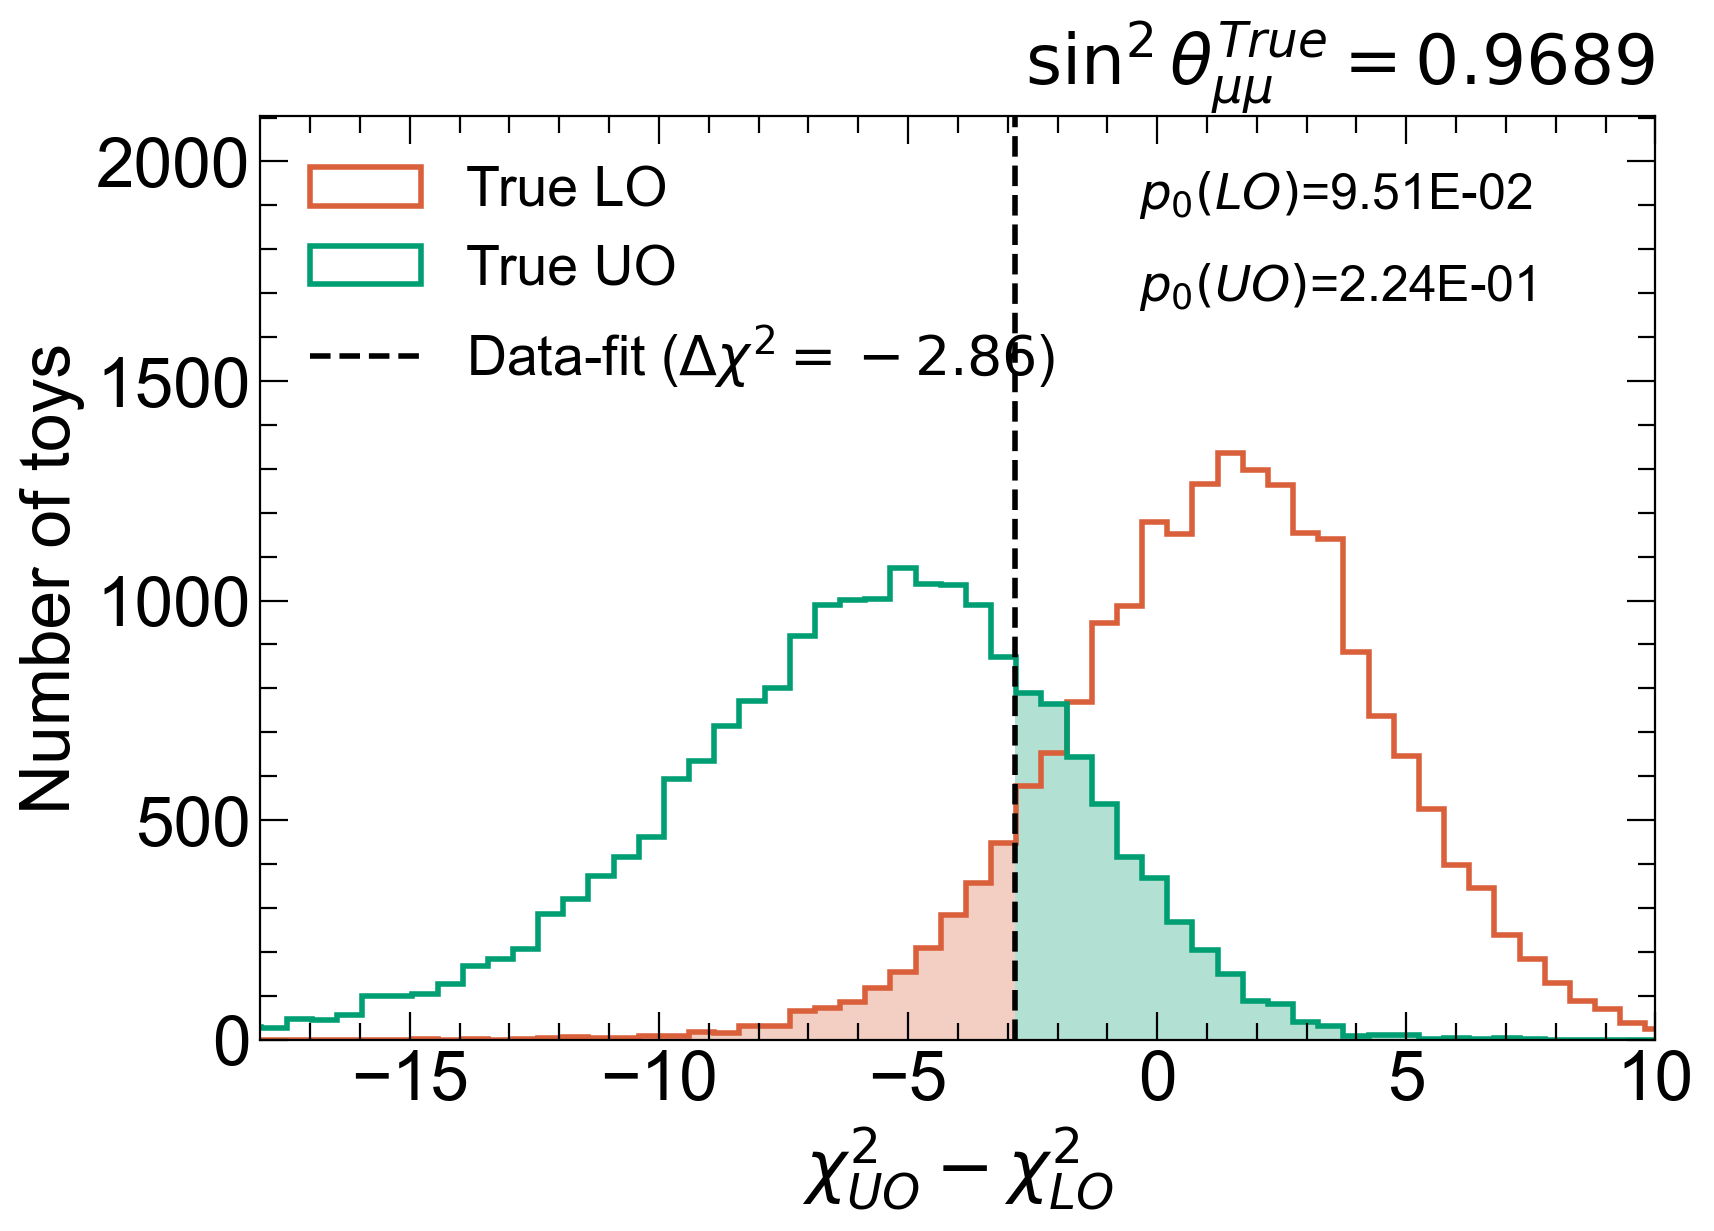

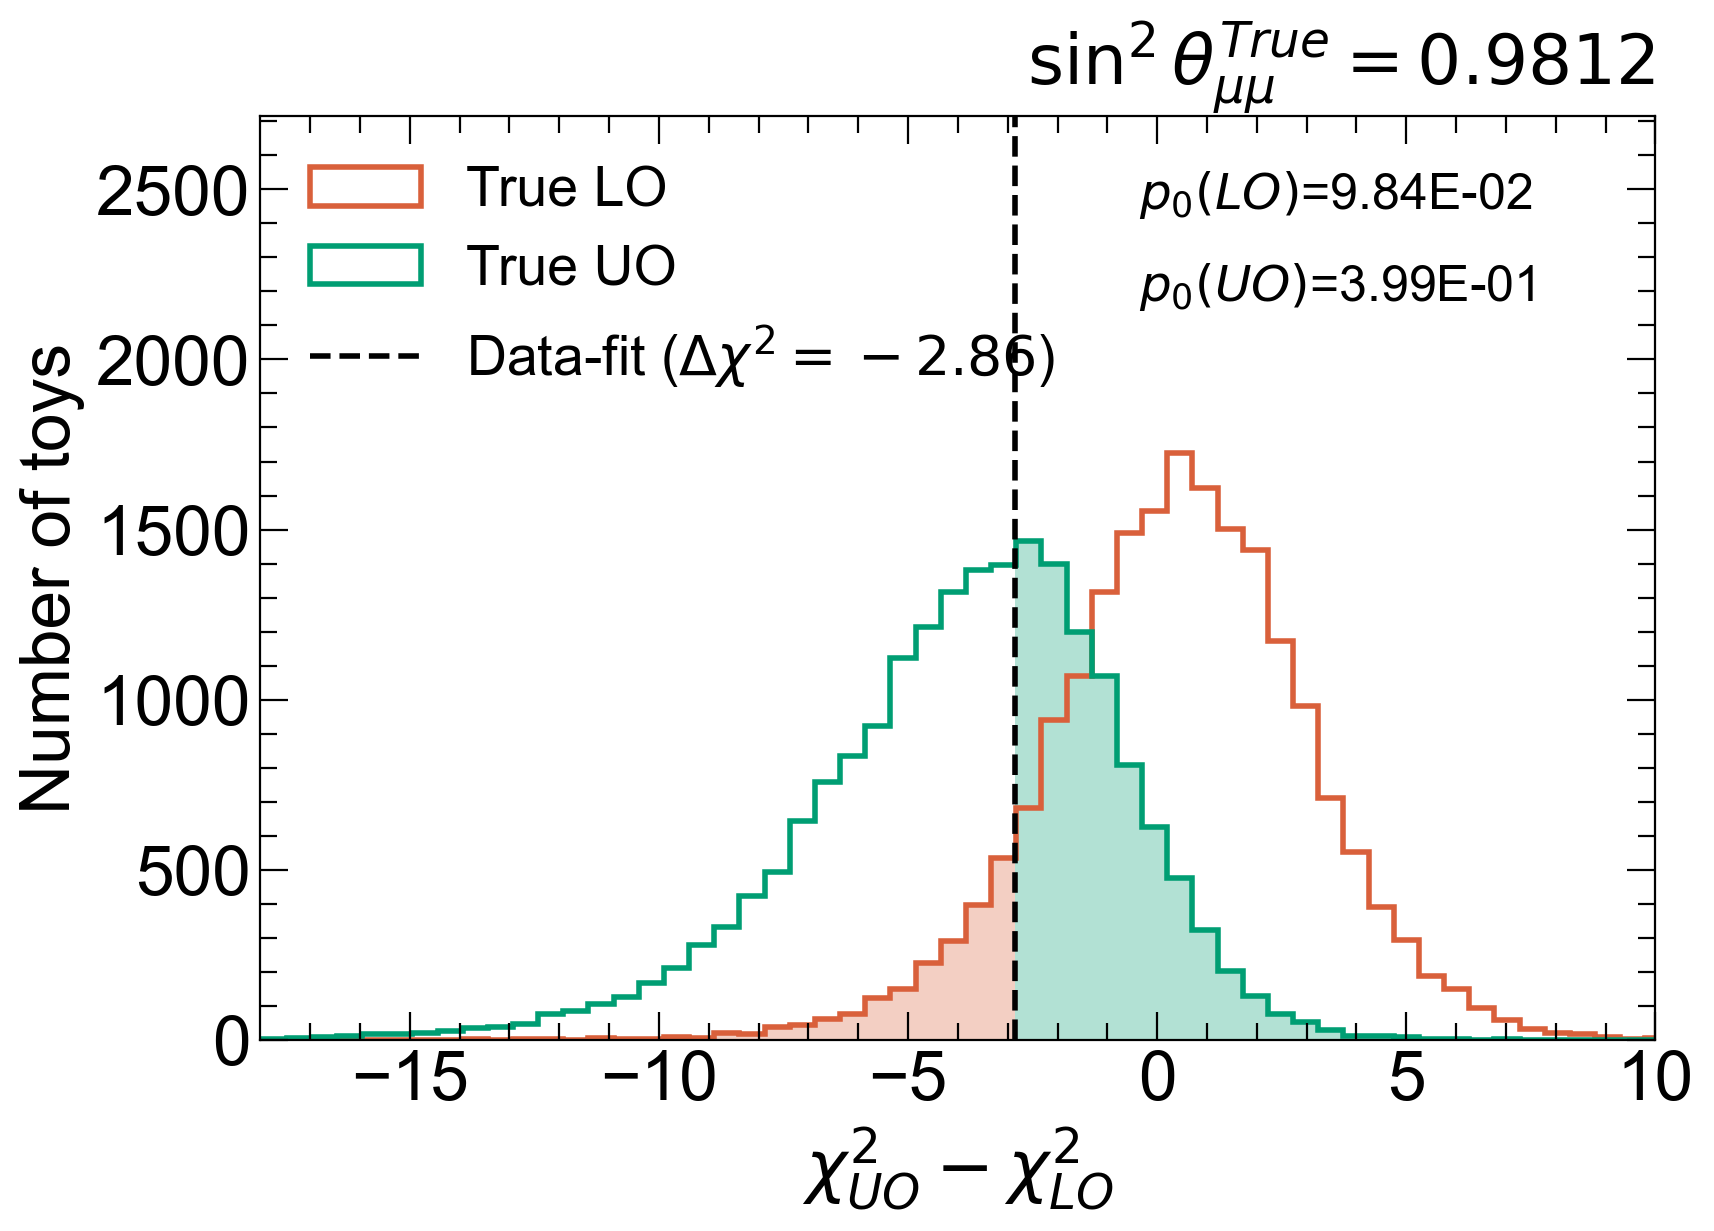

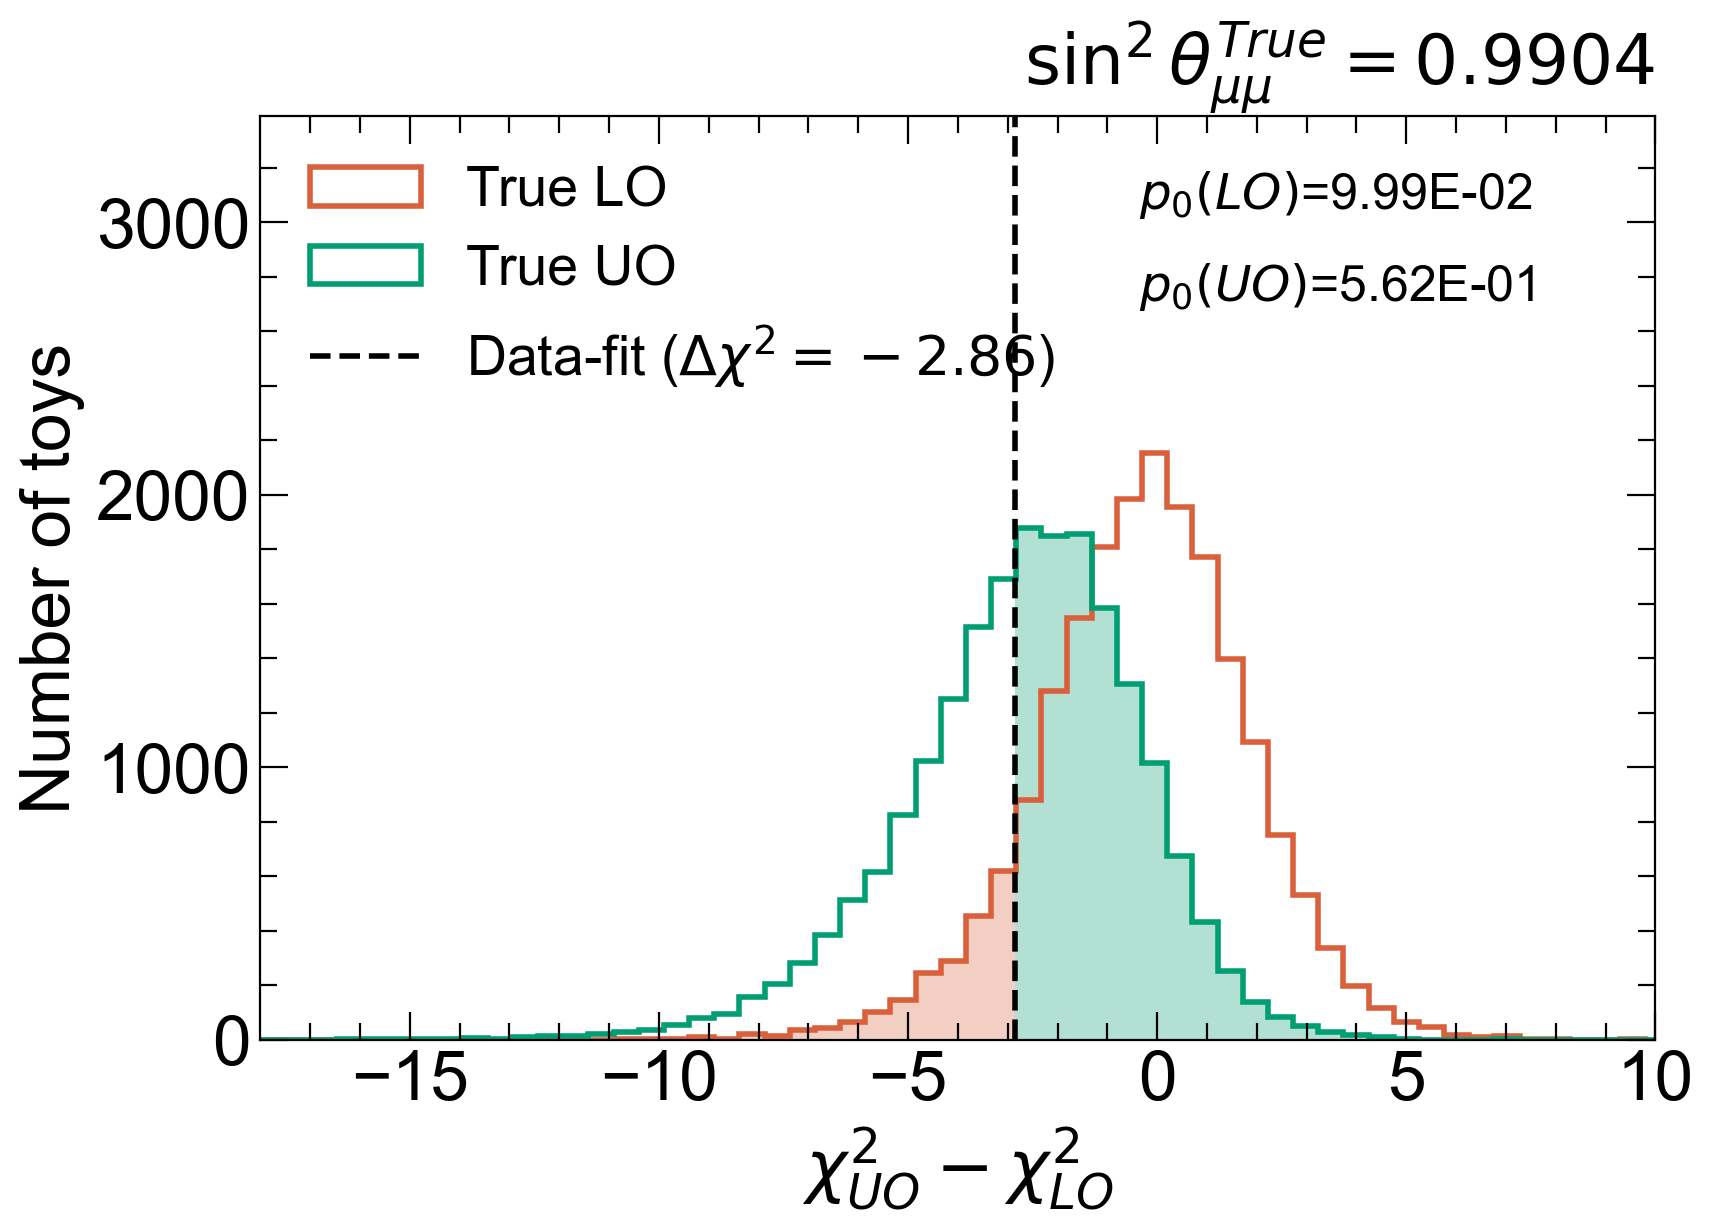

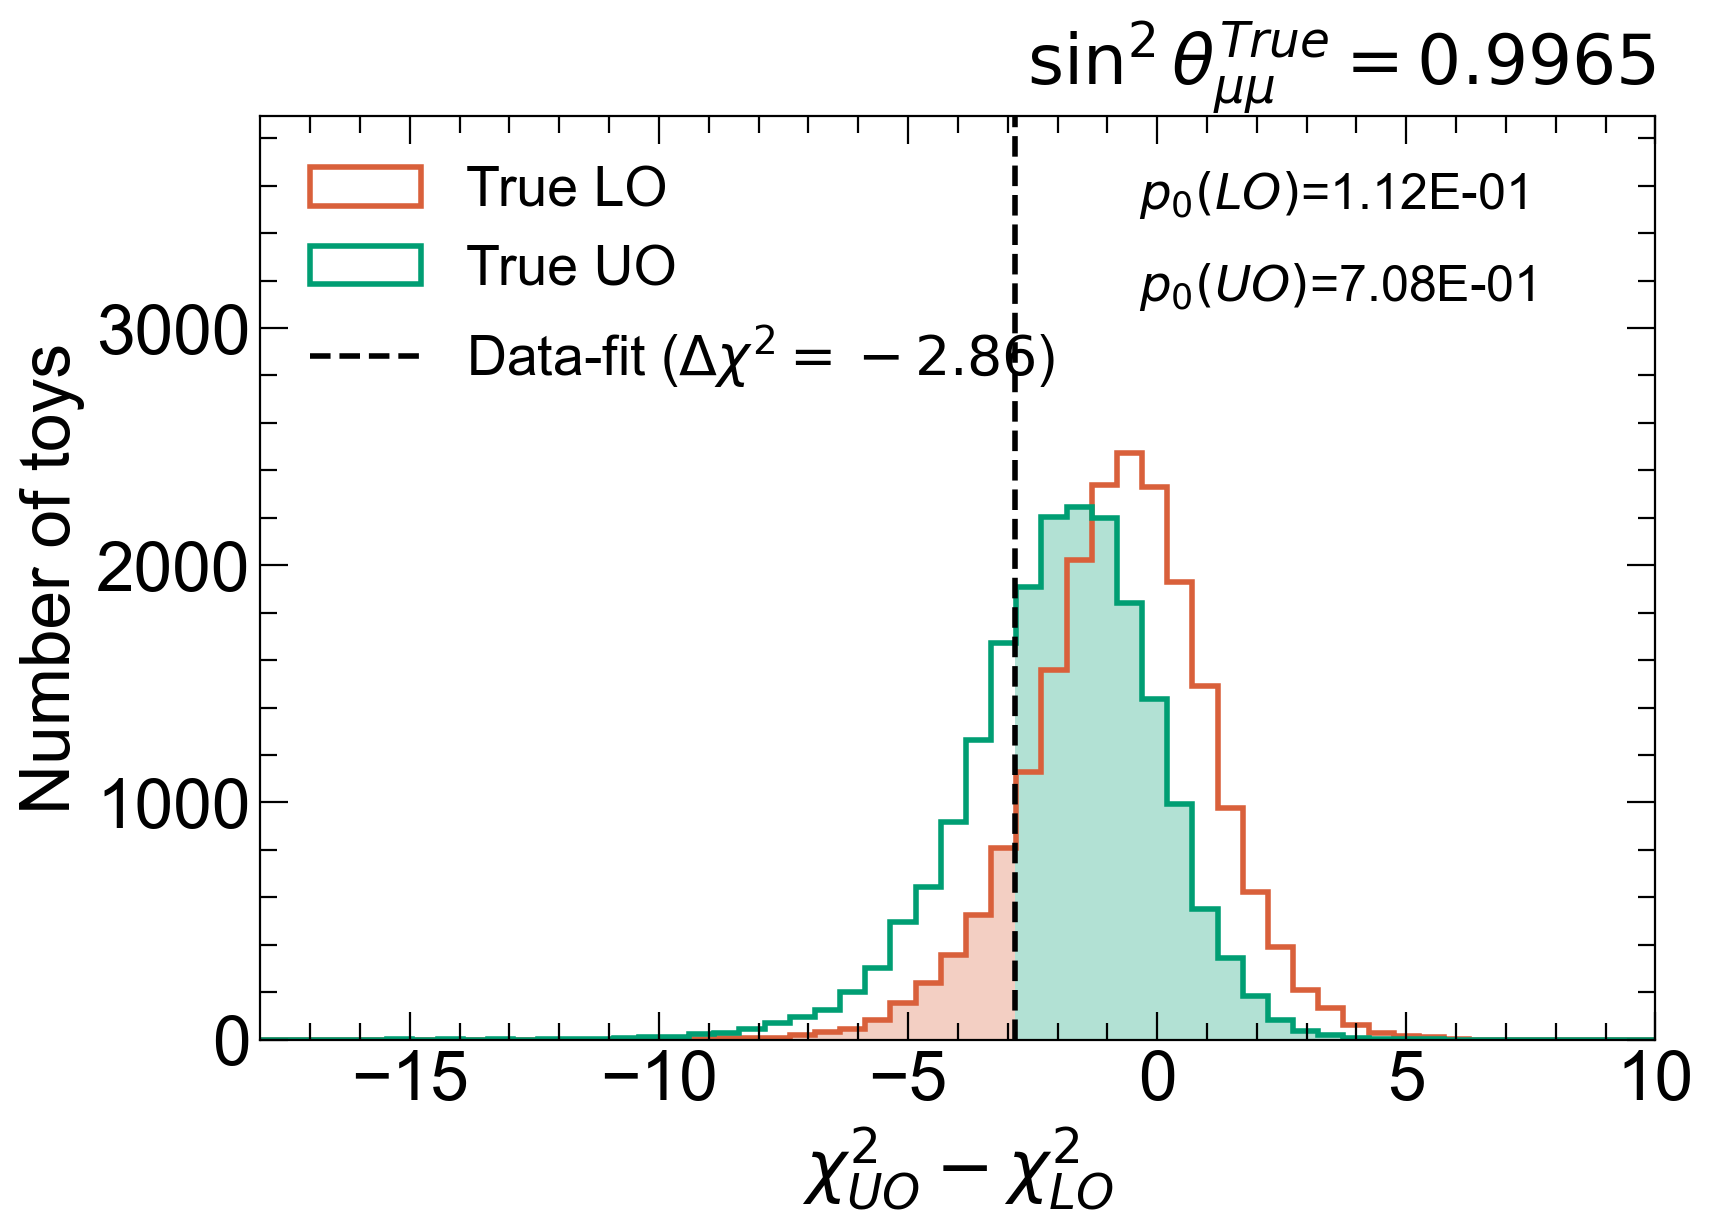

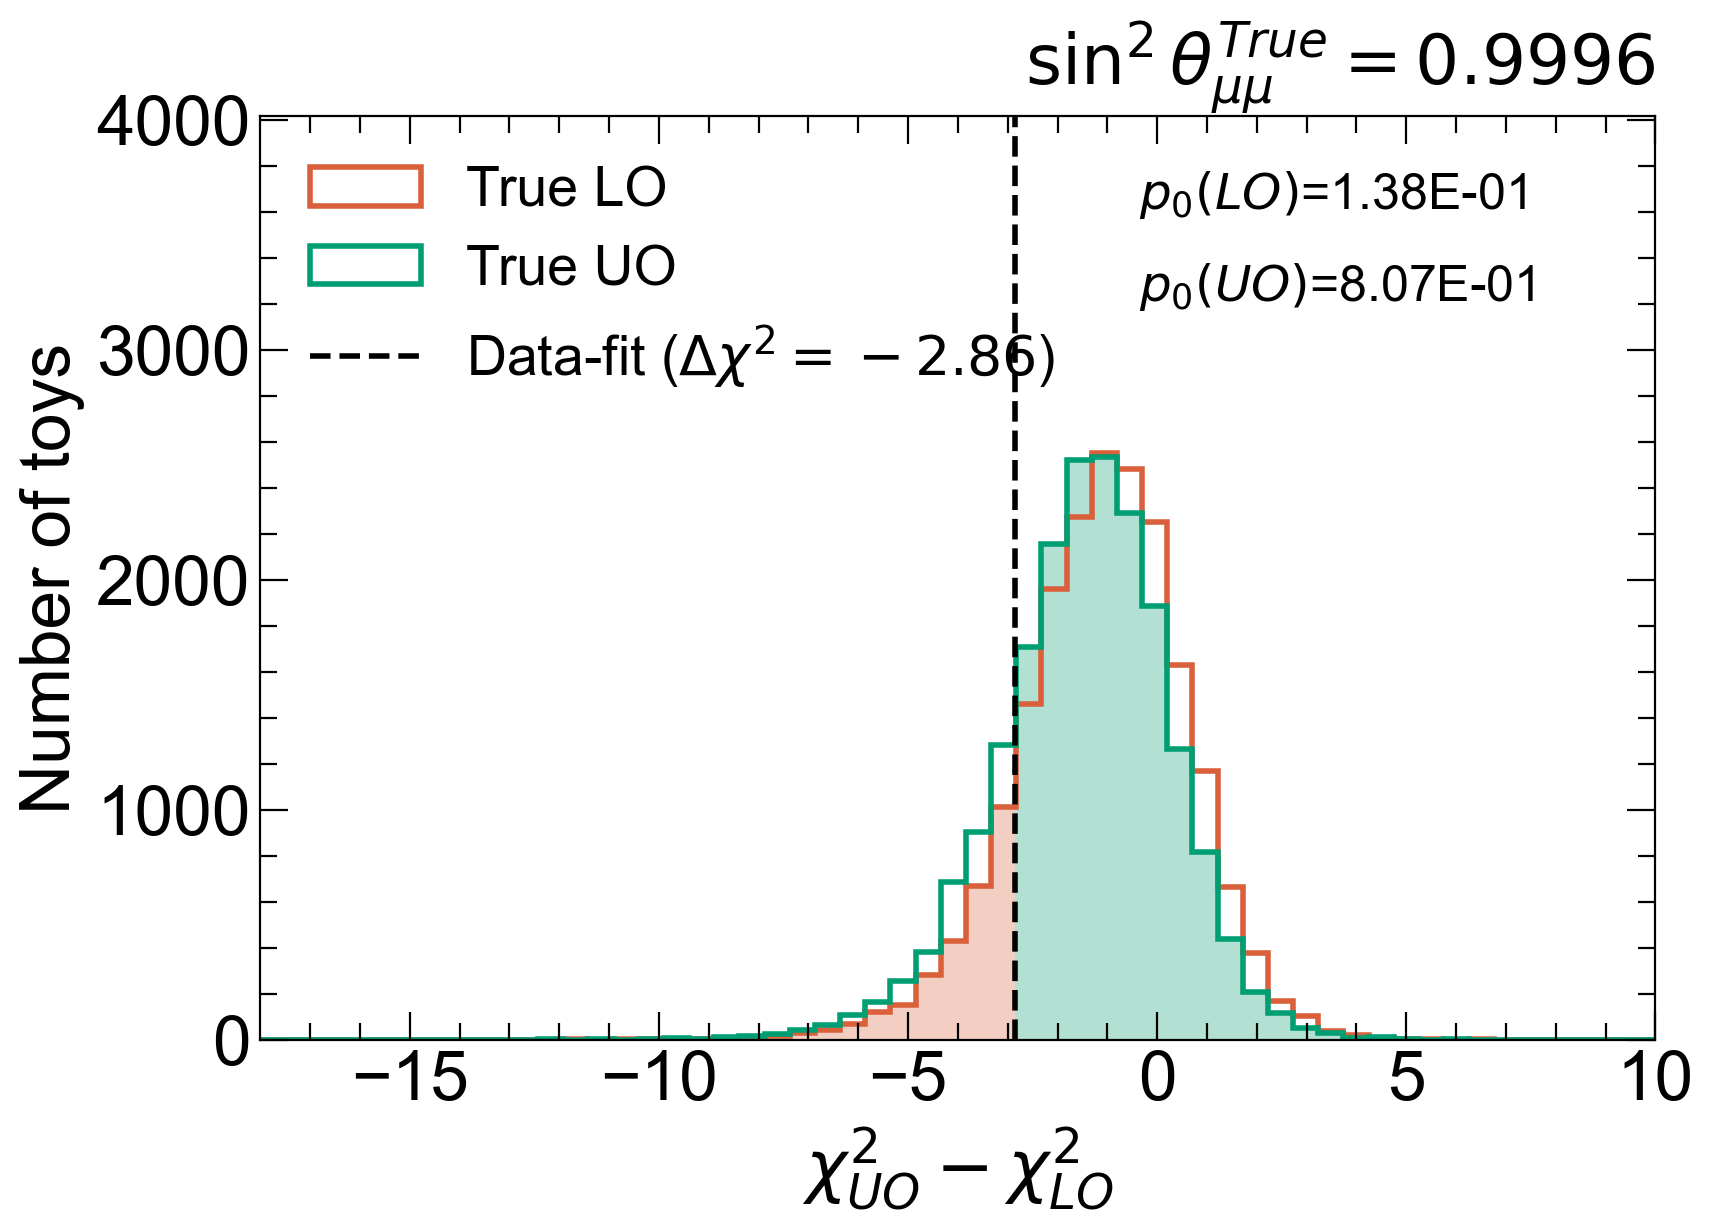

In [31]:
param = 'sin223'
dir_ver = 'OA2023'
true_mh = 0
octant_pairs = [[0.42, 0.60], [0.44, 0.58], [0.46, 0.56], [0.48, 0.54], [0.50, 0.52]]

basename_directory = f"MargTemplates_DataFit_sin223_100k_p-theta_mode_0"
base_dir_data = f"{inputs_dir}/{dir_ver}/MargTemplates/{basename_directory}"

for octant_pair in octant_pairs:
    base_dir_true_uo = f"{inputs_dir}/{dir_ver}/FC/MargTemplates_LucileThesis_fit_FCsin223_{octant_pair[0]}_{true_mh}_FullSyst_wRC_etheta_ptheta_sin223"
    base_dir_true_lo = f"{inputs_dir}/{dir_ver}/FC/MargTemplates_LucileThesis_fit_FCsin223_{octant_pair[1]}_{true_mh}_FullSyst_wRC_etheta_ptheta_sin223"
    fig, ax = plt.subplots()
    Plot_octant_dchi2(ax, base_dir_true_uo, base_dir_true_lo, base_dir_data, octant_pair)
    

# CPC studies

## Plot $\Delta \chi^2$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Number of entries in 'MargTemplate': 2040.
Grid sizes: [51] for parameters ['delta']


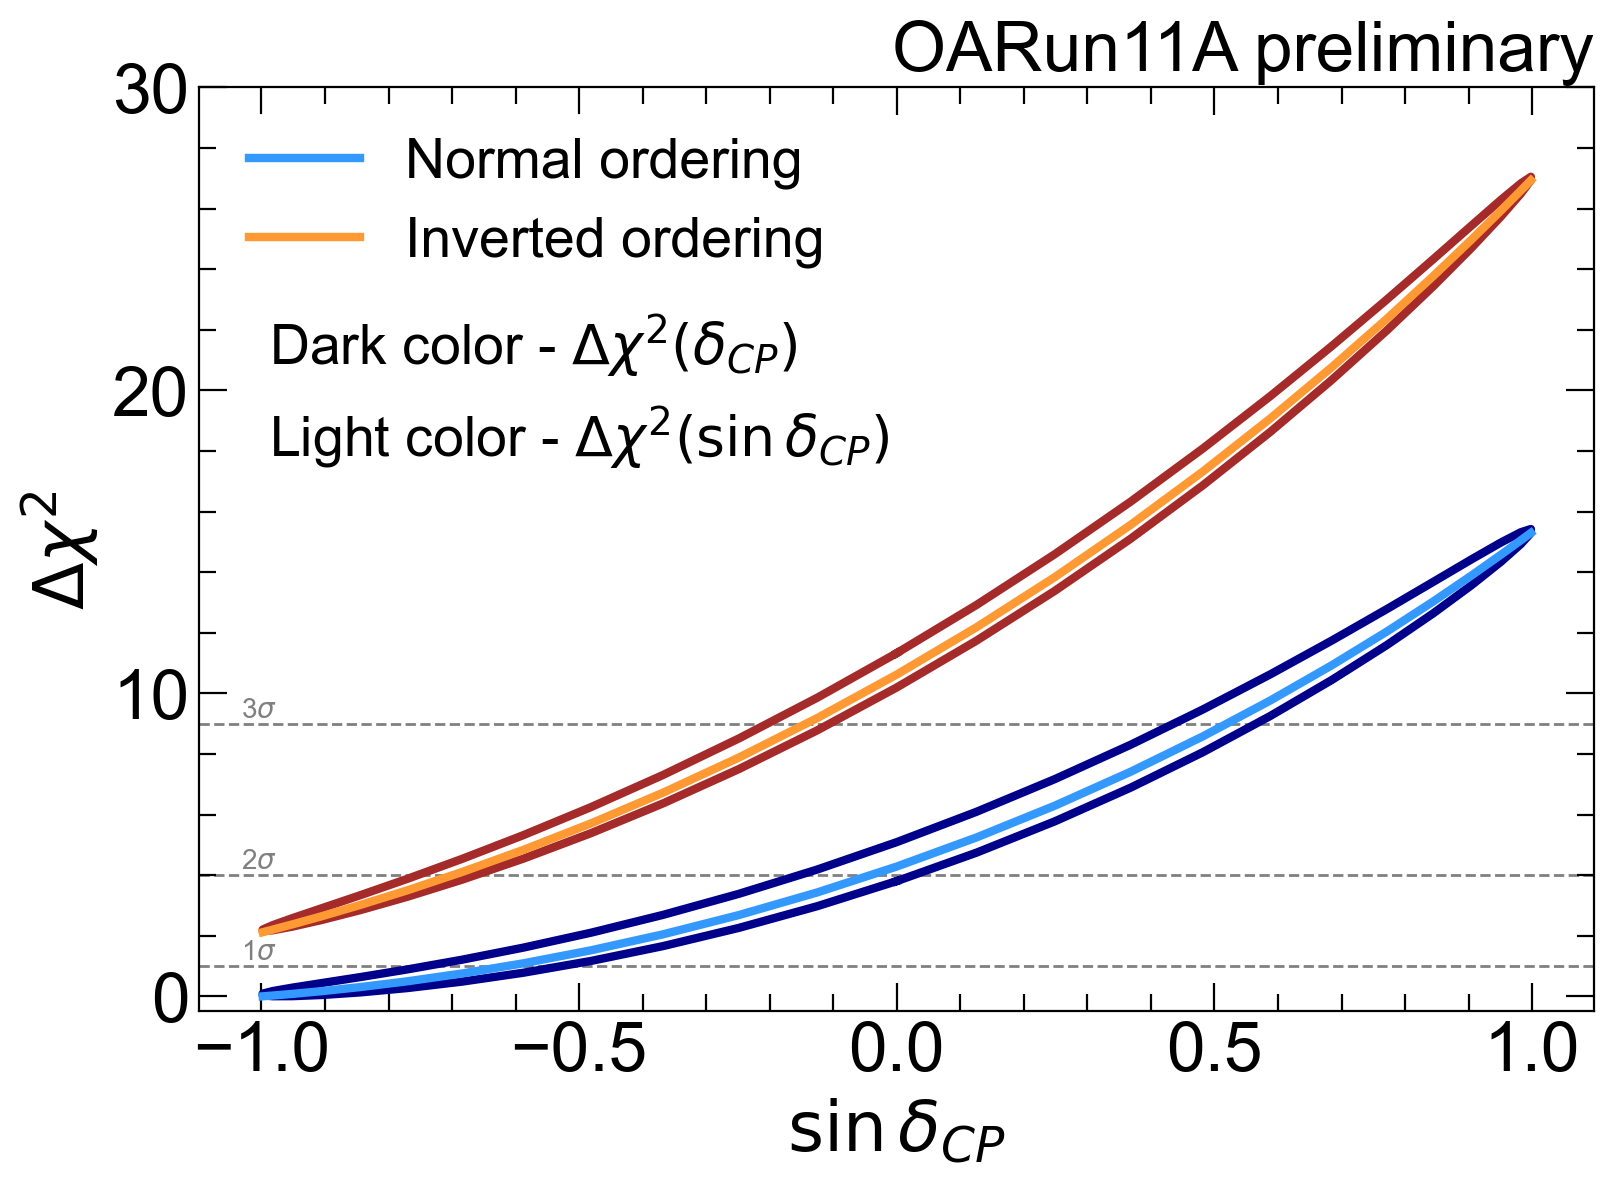

In [44]:
dir_ver = 'OA2023'
postfix = 'DataFit'

basename_directory = f"MargTemplates_DataFit_delta_100k_p-theta_mode_0"
base_dir = f"{inputs_dir}/{dir_ver}/MargTemplates/{basename_directory}"
file_pattern = f"{base_dir}/marg*.root"
grid, avnllh_df, param_name = likelihood.load(file_pattern)
llh_dcp = likelihood.Loglikelihood(grid, avnllh_df, param_name)

AvNLL_pergrid_pertoy = np.stack([avnllh_df[0], avnllh_df[1]], axis=1)

#Marginalisation on cosdelta
grid_sindcp, AvNLL_pergrid_pertoy_marg, param_name_x = pvalues.marg_cosdelta(grid[0], AvNLL_pergrid_pertoy)
avnllh_df_sindcp = {i: AvNLL_pergrid_pertoy_marg[:, i, :] for i in range(2)}
llh_sindcp = likelihood.Loglikelihood([grid_sindcp], avnllh_df_sindcp, [param_name_x])

dchi2_data_sindcp = [None]*2
for mh in [0, 1]:
    dchi2_data_sindcp[mh] = feldman_cousins.llr_distr(grid_sindcp, AvNLL_pergrid_pertoy_marg, 0, mh, param_name_x)

fig, ax = plt.subplots()

plt.plot(np.sin(llh_dcp.grid[0]), llh_dcp.dchi2[0], color='darkblue')
plt.plot(np.sin(llh_dcp.grid[0]), llh_dcp.dchi2[1], color='brown')

ax.text(0.05, 0.7, "Dark color - $\Delta \chi^2(\delta_{CP})$", transform=ax.transAxes, fontsize=20)
ax.text(0.05, 0.6, "Light color - $\Delta \chi^2(\sin \delta_{CP})$", transform=ax.transAxes, fontsize=20)

llh_sindcp.plot(ax, wtag=True)
ax.set_ylim(-0.5, 30)

fig.savefig(f"{outputs_dir}/plots/{dir_ver}/dchi2/dchi2_sindelta_main{postfix}.eps", bbox_inches='tight')
fig.savefig(f"{outputs_dir}/plots/{dir_ver}/dchi2/dchi2_sindelta_main{postfix}.pdf", bbox_inches='tight')
fig.savefig(f"{outputs_dir}/plots/{dir_ver}/dchi2/dchi2_sindelta_main{postfix}.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{outputs_dir}/plots/{dir_ver}/dchi2/dchi2_sindelta_main{postfix}.svg", bbox_inches='tight')


## Plot $\Delta \chi^2$ distribution

In [88]:

levels = [sigma_to_CL(z_score) for z_score in [1, 2, 3]]
levels = levels + [0.9]
lss = ['-', '--', 'dashdot', 'dotted']
levels.sort()
labels = ['68.27%', '90.00%', '95.45%', '99.73%']

param_name = 'sindelta'
true_param_str_1 = '3.14159265359'
true_param_str_2 = '0.0'

def Plot_CPC_dchi2(base_dir_toys_true_pi_template, base_dir_toys_true_0_template, base_dir_toys_true_CPV, base_dir_data, zero_over_pi_ratio, postfix, save=True):
    true_param = 0 #we test CPC sindelta=0

    file_pattern = f"{base_dir_data}/marg*.root"
    grid, avnllh_df, param_name = likelihood.load(file_pattern)
    AvNLL_pergrid_pertoy = np.stack([avnllh_df[0], avnllh_df[1]], axis=1)
    grid_sindcp, AvNLL_pergrid_pertoy_marg, param_name_x = pvalues.marg_cosdelta(grid[0], AvNLL_pergrid_pertoy)
    dchi2_data = [None]*2
    for mh in [0, 1]:
        dchi2_data[mh] = feldman_cousins.llr_distr(grid_sindcp, AvNLL_pergrid_pertoy_marg, 0, mh, param_name_x)[0]
    
    for true_mh in [0, 1]:
        fig, ax = plt.subplots()
        base_dir_toys_true_0 = Path(base_dir_toys_true_pi_template.format(true_mh=true_mh))
        base_dir_toys_true_pi = Path(base_dir_toys_true_pi_template.format(true_mh=true_mh))
        
        pattern_pi = f"{base_dir_toys_true_pi}/marg*.root"
        pattern_0 =  f"{base_dir_toys_true_0}/marg*.root"   
        grid_x, AvNLL_pergrid_pertoy_pi, param_name_x = likelihood.load_1D_array([pattern_pi])
        grid_x, AvNLL_pergrid_pertoy_0, param_name_x = likelihood.load_1D_array([pattern_0])
        
        AvNLL_pergrid_pertoy = np.vstack((AvNLL_pergrid_pertoy_pi, AvNLL_pergrid_pertoy_0[0:int(AvNLL_pergrid_pertoy_0.shape[0]*zero_over_pi_ratio)]))
        grid_x, AvNLL_pergrid_pertoy, param_name_x = pvalues.marg_cosdelta(grid_x, AvNLL_pergrid_pertoy)
        dchi2_cpc = feldman_cousins.llr_distr(grid_x, AvNLL_pergrid_pertoy, true_param, true_mh, param_name_x)
        pvalues.plot_dchi2_distr(ax, dchi2_cpc, dchi2_data[true_mh], 0, f"True CPC", False, 'CPC')
        
    
        pattern_cpv = f"{base_dir_toys_true_CPV}/marg*.root"
    
        grid_x, AvNLL_pergrid_pertoy, param_name_x = likelihood.load_1D_array([pattern_cpv])
        grid_x, AvNLL_pergrid_pertoy, param_name_x = pvalues.marg_cosdelta(grid_x, AvNLL_pergrid_pertoy)
        dchi2_cpv = feldman_cousins.llr_distr(grid_x, AvNLL_pergrid_pertoy, true_param, true_mh, param_name_x)
        pvalues.plot_dchi2_distr(ax, dchi2_cpv, dchi2_data[true_mh], 1, f"Max CPV", True, 'CPC')
    
        p_cpc = pvalues.get_pvalue(dchi2_cpc, dchi2_data[true_mh], 'right')
        p_cpv = pvalues.get_pvalue(dchi2_cpv, dchi2_data[true_mh], 'left')
    
        percentiles_cpc = pvalues.get_percentiles(dchi2_cpc)
        percentiles_cpv = pvalues.get_percentiles(dchi2_cpv)
    
        ax.axvline(dchi2_data_sindcp[true_mh], color='black', 
                   label=f'Data result: $\Delta \chi^2={np.round(dchi2_data[true_mh], 2)}$', ls='--', linewidth=2)
    
        
        ax.set_yscale('log')
        ax.set_xlabel("$\chi^2_{CPC} - \chi^2_{CPV}$")
        ax.legend(framealpha=0, loc='upper right', fontsize=18)
        ax.set_title(f'True {mo_to_title[true_mh]}', loc='right')
        ax.text(0.70, 0.65, f'$p_{{0}}(CPC)$={pvalues.round_to_3(p_cpc)}', transform=ax.transAxes, fontsize=15 )
        ax.text(0.70, 0.58, f'$p_{{0}}(MCPV)$={pvalues.round_to_3(p_cpv)}', transform=ax.transAxes, fontsize=15 )
    
        fig.savefig(f'{outputs_dir}/plots/{dir_ver}/pvalues/CPC_truemh{true_mh}{postfix}.pdf', bbox_inches='tight')
    
                

Number of entries in 'MargTemplate': 2040.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']


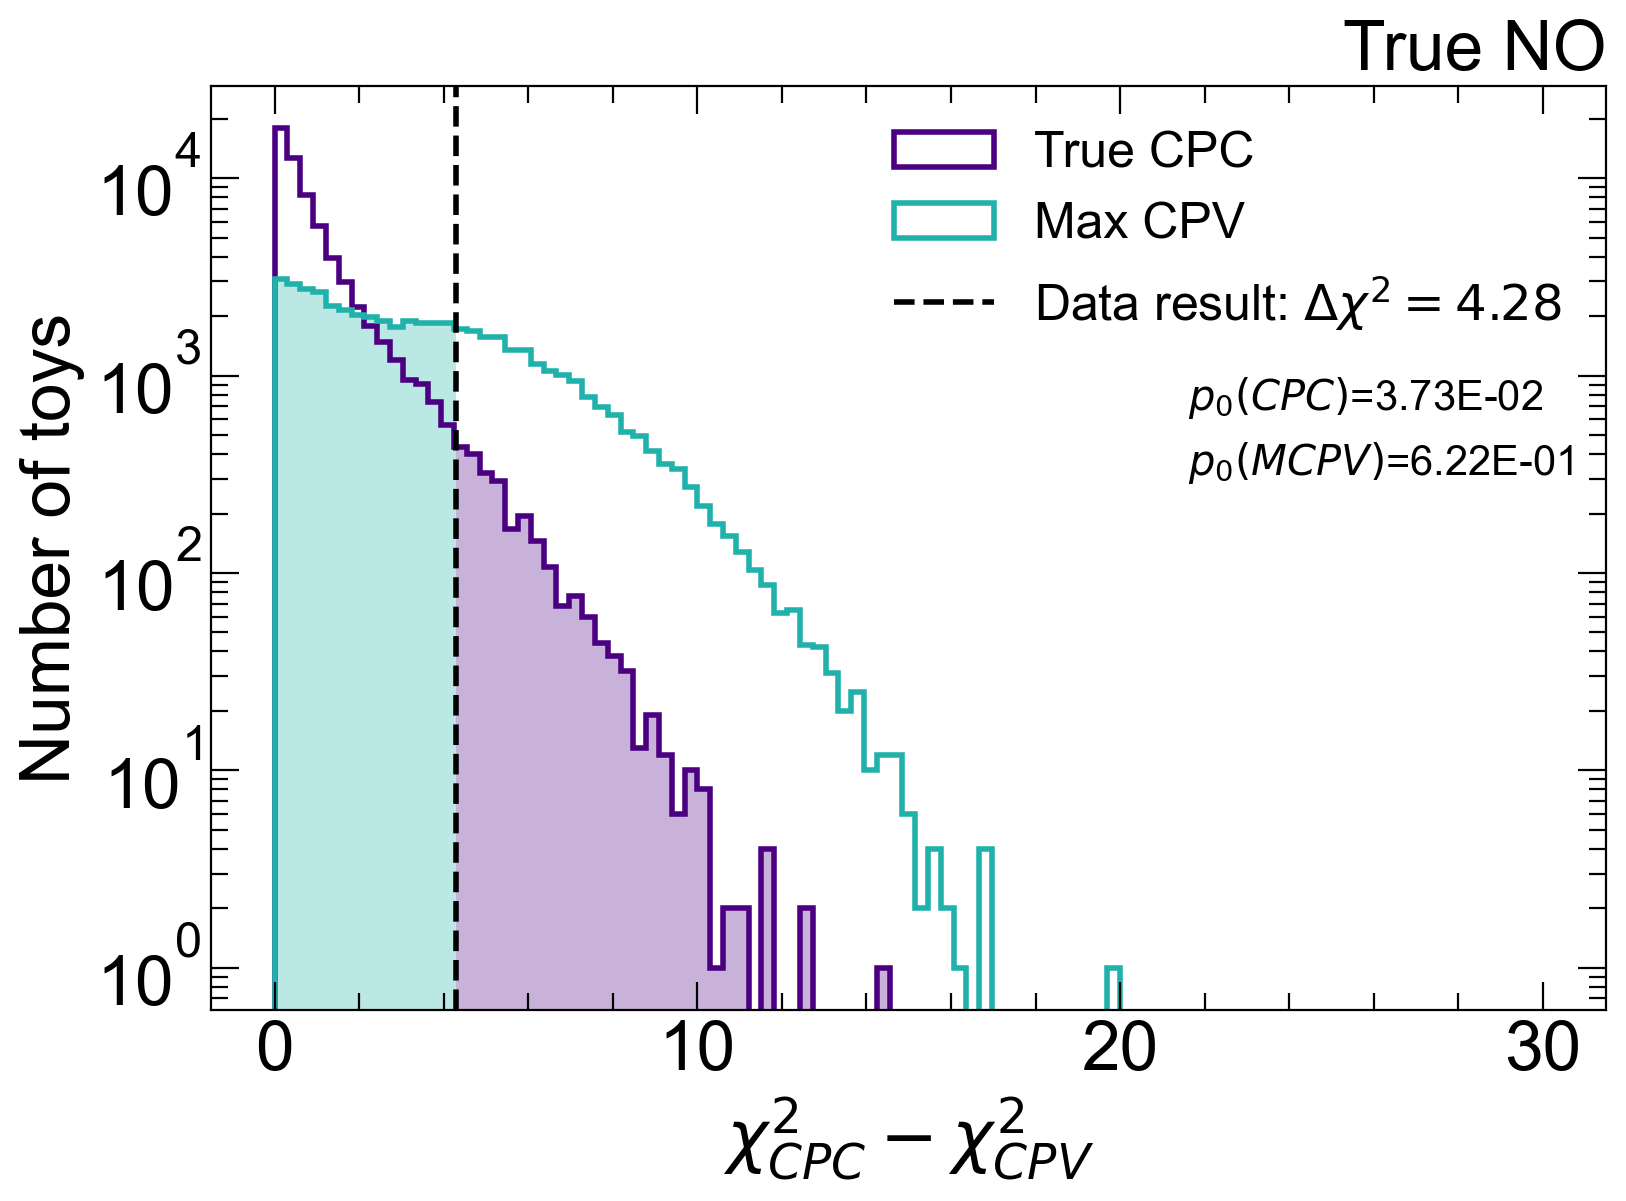

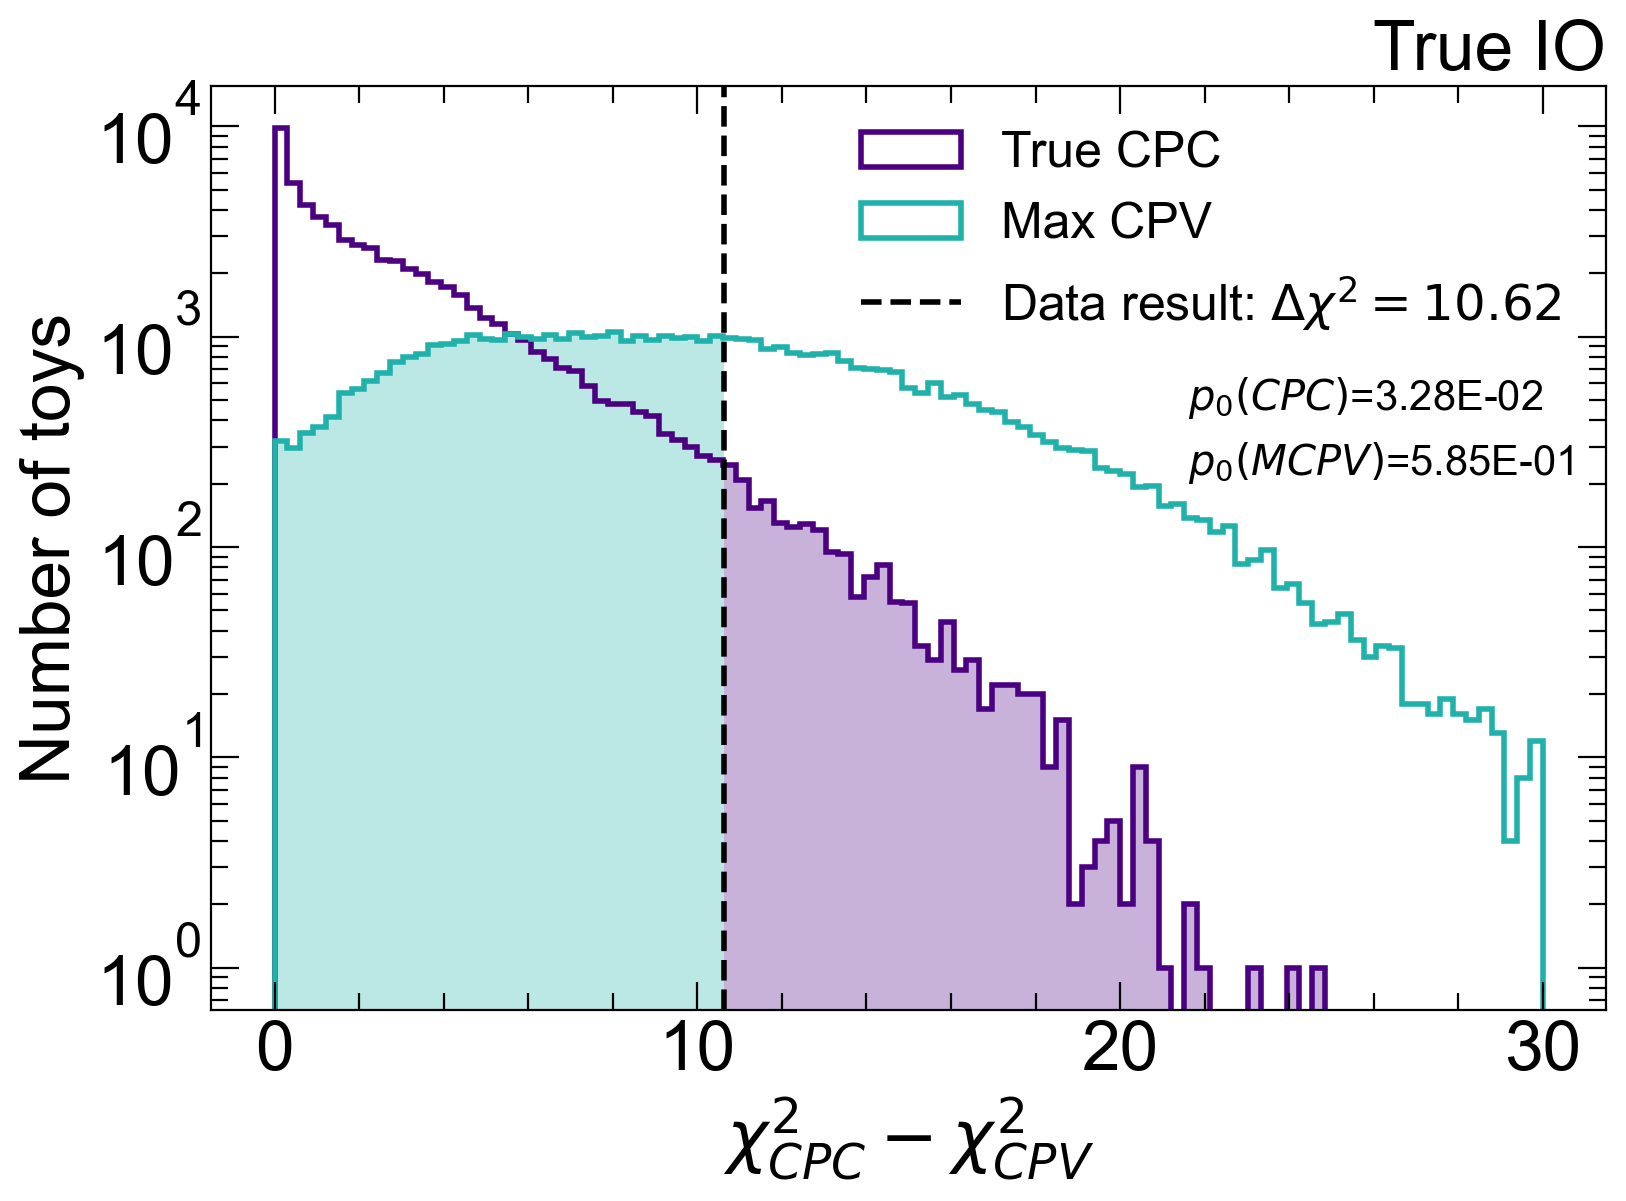

In [89]:
zero_over_pi_ratio = np.exp(-(llh_dcp.dchi2[0][len(llh_dcp.dchi2[0])//2] - llh_dcp.dchi2[0][0])) #ratio between 0 and pi taken from data posterior

base_dir_data = f"{inputs_dir}/{dir_ver}/MargTemplates/MargTemplates_DataFit_delta_100k_p-theta_mode_0"
base_dir_toys_true_pi_template = f"{inputs_dir}/{dir_ver}/FC/MargTemplates_LucileThesis_fit_FC_3.14159265359_{true_mh}_FullSyst_wRC_etheta_ptheta_delta/"
base_dir_toys_true_0_template = f"{inputs_dir}/{dir_ver}/FC/MargTemplates_LucileThesis_fit_FC_0.0_{true_mh}_FullSyst_wRC_etheta_ptheta_delta/"
base_dir_toys_true_CPV = f"{inputs_dir}/{dir_ver}/FC/MargTemplates_LucileThesis_fit_FC_-1.57079632679_{true_mh}_FullSyst_wRC_etheta_ptheta_delta"

Plot_CPC_dchi2(base_dir_toys_true_pi_template, base_dir_toys_true_0_template, base_dir_toys_true_CPV, base_dir_data,
               zero_over_pi_ratio, postfix='max_cpv', save=True)
